# Capstone Project: Compare Consumer Sentiments of Apple, Google, and Android from Past to Present

**Instructor:**James Irving <br>
**Date:**7/23/21

**Business Problem:** For better or worse, people's perception of tech giants have changed over time. A company that consults these large companies' PR teams have hired me to find how the consumers' sentiments have changed. To gather the necessary information, I am going to go to Twitter, and I will compare the public's emotion towards these companies using vader sentiment analysis.

In [157]:
import tweepy as tw
import os
import pandas as pd
import json
import csv
from datetime import date
from datetime import datetime
import time
import numpy as np
import re
import html
import matplotlib.pyplot as plt
import string
import streamlit as st
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline

import nltk
from nltk import tokenize
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer, word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords, subjectivity
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')


from wordcloud import WordCloud

import spacy
import sklearn
print(sklearn.__version__)
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

0.24.1


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yslim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yslim\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yslim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yslim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Overview

For the initial data collection, I used the dataset provided from https://data.world/crowdflower/brands-and-product-emotions for the old Twitter data and used Tweepy and Twitter's developer API to collect new Twitter data. The main goal of this project was to see how people's sentiment towards these companies have changed over time. Apple, for example, was a company founded on creating innovative, consumer-friendly products; however, they began prioritizing profits more than the end user's experience. The iPhones and mac books have become more difficult to fix and reuse, and have artificially obsoleted features such as the head-phone jack. As many of these companies began prioritizing earnings over all else, I wanted to see how the consumers' perception towards them have changed in comparison to the past. 

## Data Cleaning

### Old Tweet
This data frame contains old tweets from around 2013 and before, as mentioned above, the dataset was acquired from https://data.world/crowdflower/brands-and-product-emotions. After the cleaning there was a total of 8,306 tweets from a previous total of 9,092 tweets.

In [6]:
old_tweet_df=pd.read_csv('data/tweet_product_company.csv', encoding='latin_1')
old_tweet_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [7]:
# First we need to see if there are tweets that have no text and were able to find one tweet without any text
old_tweet_df.loc[old_tweet_df['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [8]:
old_tweet_df.dropna(subset=['tweet_text'], inplace=True)
old_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [9]:
#Changed the column names since they were long and seemed unnecessary
change_dict={'emotion_in_tweet_is_directed_at':'product or company', 
             'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}
old_tweet_df.rename(columns=change_dict, inplace=True)
old_tweet_df

,tweet_text,product or company,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product


In [10]:
# We want to know what kind of emotion and the number of emotions shown in the tweets
old_tweet_df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [11]:
# Because the emotions were labeled as "I can't tell", pandas didn't recognize it as missing values
old_tweet_df[old_tweet_df['emotion'].isna()]

,tweet_text,product or company,emotion


In [12]:
# Here I wanted to see what companies and how many companies/brands there were per emotion
old_tweet_df.groupby(by=['emotion', 'product or company'], dropna=False).count()


tweet_text
emotion                            product or company                         
I can't tell                       Apple                                     2
                                   Google                                    1
                                   Other Google product or service           1
                                   iPad                                      4
                                   iPhone                                    1
                                   NaN                                     147
Negative emotion                   Android                                   8
                                   Android App                               8
                                   Apple                                    95
                                   Google                                   68
                                   Other Apple product or service            2
                                   Other Google product or service          47
                                   iPad                                    125
                                   iPad or iPhone App                       63
                                   iPhone                                  103
                                   NaN                                      51
No emotion toward brand or product Android                                   1
                                   Android App                               1
                                   Apple                                    21
                                   Google                                   15
                                   Other Apple product or service            1
                                   Other Google product or service           9
                                   iPad                                     24
                                   iPad or iPhone App                       10
                                   iPhone                                    9
                                   NaN                                    5297
Positive emotion                   Android                                  69
                                   Android App                              72
                                   Apple                                   543
                                   Google                                  346
                                   Other Apple product or service           32
                                   Other Google product or service         236
                                   iPad                                    793
                                   iPad or iPhone App                      397
                                   iPhone                                  184
                                   NaN                                     306

In [13]:
#We are creating a dataframe that contains all duplications where the value for product or company is missing
duplications=old_tweet_df.duplicated(subset=['tweet_text'], keep='first')
old_tweet_df[duplications]

,tweet_text,product or company,emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,No emotion toward brand or product
2232,Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,NaN,No emotion toward brand or product
2559,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion
3813,Win free ipad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
3814,Win free iPad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW,Android App,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
4897,"Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!",iPad or iPhone App,Positive emotion
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,NaN,No emotion toward brand or product


In [14]:
clean_old_df=old_tweet_df.loc[~duplications].copy()
clean_old_df

,tweet_text,product or company,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product


In [15]:
# Tell why i did this
# Here I want to see the number of each emotions where the product or company's values is missing.
# Now we can see that most of the tweets that do not have a company show no emotion (neutral emotion)
clean_old_df[clean_old_df['product or company'].isna()]['emotion'].value_counts()

No emotion toward brand or product    5281
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: emotion, dtype: int64

In [16]:
# Lump apple products as Apple instead of having different products
# This is still cleaning for the older tweets
brands2={'Google':'Google', 'Apple' : 'Apple', 'Android': 'Android', 'iPad':'Apple', 'i-pad':'Apple' ,'iPhone': 'Apple'}
for key, values in brands2.items():
    clean_old_df.loc[clean_old_df['tweet_text'].str.contains(key, case=False), 'product or company']= values

In [17]:
# After running the for loop above, we can see a clear decrease in the number of tweets 
# that do not contain a company or product
clean_old_df[clean_old_df['product or company'].isna()]['emotion'].value_counts()

No emotion toward brand or product    739
Positive emotion                       13
I can't tell                            6
Negative emotion                        1
Name: emotion, dtype: int64

In [18]:
clean_old_df

,tweet_text,product or company,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Apple,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Apple,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Apple,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Apple,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},Apple,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",Google,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",Google,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,Apple,No emotion toward brand or product


In [19]:
# Though I have already seen the total number of tweets without a product or company, I wanted to
# double check and make sure that the tweets indeed did not contain a company or product name
clean_old_df[clean_old_df['product or company'].isna()]

,tweet_text,product or company,emotion
51,"ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,&amp; ppl who can help us JAM #libya #SXSW",NaN,No emotion toward brand or product
52,÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,NaN,No emotion toward brand or product
53,".@mention @mention on the location-based 'fast, fun and future' - {link} (via @mention #sxsw",NaN,No emotion toward brand or product
66,At #sxsw? @mention / @mention wanna buy you a drink. 7pm at Fado on 4th. {link} Join us!,NaN,No emotion toward brand or product
71,Chilcott: @mention #SXSW stand talking with Blogger staff. Too late to win competition for best tweet mentioning @mention So no t-shirt.,NaN,No emotion toward brand or product
...,...,...,...
8932,Z6: No News is Good News {link} [codes valid: 4:00-7:59:59p 03/11/11] #infektd #sxsw #zlf,NaN,No emotion toward brand or product
8936,CLIENT NEWS! @mention Releases &quot;Dope Melodies &amp; Heavy Bass&quot; &amp; Invades #SXSW -&gt; {link},NaN,No emotion toward brand or product
8970,This is my 5th year downloading the #sxsw Music Torrent {link} ALL FREE and LEGAL! Great Music.,NaN,No emotion toward brand or product
9024,"by the way, we're looking for a spanish-speaking trend scout based in Austin -&gt; {link} #sxsw",NaN,No emotion toward brand or product


In the next two lines of code, I am just repeating the above process but just looking at it in more detail for positive and negative emotions.


In [20]:
# tell what i was looking for/ why i did this for basically most of the lines
clean_old_df.loc[(clean_old_df['emotion']=='Positive emotion') & (clean_old_df['product or company'].isna())]

,tweet_text,product or company,emotion
619,"@mention hello! Enjoy #Sxsw and ride anywhere in Austin for $10 . download the #GroundLink app, {link} booth 437",NaN,Positive emotion
1366,"@mention - spread the word, our #SXSW festival explorer App is live and free {link}",NaN,Positive emotion
2258,@mention be sure to use our FREE App for checking out the bands at #SXSW! {link},NaN,Positive emotion
3034,"Free iTunes Album, #SXSW Featured Artists, grab it if you missed it: {link}",NaN,Positive emotion
3747,{link} Coinsidence? Sounds like a good strategy to me. Wish I could go to #SXSW,NaN,Positive emotion
4237,@mention Luckily @mention has a pop up store at #SXSW!,NaN,Positive emotion
5613,RT @mention Check out the new @mention app {link} - this is gonna be HUGE next week at #sxsw and beyond.,NaN,Positive emotion
5746,"RT @mention Free iTunes Album, #SXSW Featured Artists, grab it if you missed it: {link}",NaN,Positive emotion
6676,RT @mention Soundtrckr featured by @mention @mention as a Must-have for #SXSW {link},NaN,Positive emotion
7825,Watch this @mention #sxsw - #ecademy @mention {link} &gt;&gt; fascinating &amp; so true about maps saving itme - lots of it,NaN,Positive emotion


In [21]:
clean_old_df.loc[(clean_old_df['emotion']=='Negative emotion') & (clean_old_df['product or company'].isna())]

,tweet_text,product or company,emotion
7561,"Apps distract pubs, sez Khoi Vinh. Instead of focusing on reader exp, they're delivering same content 3 ways. #SXSW {link}",NaN,Negative emotion


In [22]:
# I have noticed that most of the tweets that used to contain a link had a {link} place holder.
# However, I wasn't sure if all of the links were replaced with the place holder.
clean_old_df[clean_old_df['tweet_text'].str.contains("http[^ ]+|www\.[^ ]+")]

,tweet_text,product or company,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,Apple,No emotion toward brand or product
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,Apple,Positive emotion
11,Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.,Android,Positive emotion
12,"Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by far, best looking Android app to date.",Android,Positive emotion
13,Gotta love this #SXSW Google Calendar featuring top parties/ show cases to check out. RT @hamsandwich via @ischafer =&gt;http://bit.ly/aXZwxB,Google,Positive emotion
14,Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l,Apple,Positive emotion
15,"haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw",Apple,Positive emotion
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,Apple,No emotion toward brand or product
19,Must have #SXSW app! RT @malbonster: Lovely review from Forbes for our SXSW iPad app Holler Gram - http://t.co/g4GZypV,Apple,Positive emotion
23,"Photo: Just installed the #SXSW iPhone app, which is really nice! http://tumblr.com/x6t1pi6av7",Apple,Positive emotion


Unfortunately, my concern was true.<br>
The next code will look for special characters as they will need to be replaced before performing the vader sentiment analysis.

In [23]:
clean_old_df[clean_old_df['tweet_text'].str.contains('[^\x00-\x7F]+')]


,tweet_text,product or company,emotion
38,@mention - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW,Google,Negative emotion
41,"HootSuite - HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android: Whether youÛªre getting friend... {link}",Apple,No emotion toward brand or product
42,Hey #SXSW - How long do you think it takes us to make an iPhone case? answer @mention using #zazzlesxsw and weÛªll make you one!,Apple,No emotion toward brand or product
45,#IPad2 's Û÷#SmartCoverÛª Opens to Instant Access - I should have waited to get one! - {link} #apple #SXSW,Apple,Positive emotion
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link},Apple,Positive emotion
...,...,...,...
8925,umm that would be @mention ÛÏ@mention I keep winning shit! Thanks @mention for the killer iPad case. #sxswÛ,Apple,Positive emotion
8945,FestivalExplorer iPhone App Finally Solves SXSW {link} #music #musica #musiek #musique #musik #app #sxsw #Ù_¾¬â #Ù_¾´_ #Î¥É,Apple,Positive emotion
8963,"Group #Texting War Heats Up: Fast Society Launches New Android App, Updates iPhone App: #SXSWÛ_ {link}",Apple,Positive emotion
8982,"In case my fairy god mother = reading mail; my ÌÙ±G wish this week is 2 go 2 #sxsw Ï for the #Android ÏÎ Dev Ïà Meetup. @mention Hilton, Sat. 12:30PM",Android,No emotion toward brand or product


There were more number of tweets containing urls and special characters than I had initially expected. So I will need to create a function that will be able to remove special characters including emojis and other punctuation marks. The function will also replace all urls with the {link} place holder, but because I do not want the place holder to have an impact later on the word clouds, the place holders are will also be removed.

In [24]:
# Don't want any http or www. to have influence on word cloud later.
# First we will remove all non ascii characters
# Then we will remove the control characters
# Realized that standalone numbers should be removed as well
# Remove retweets, mentions, and hashtags
# Finally we have to remove unnecessary spaces

def text_cleaner(text):
    text=html.unescape(text)
    
    #remove links and urls
    links=re.findall("http[^ ]+|www\.[^ ]+", text)
    for link in links:
        text=str.replace(text, link, '{link}')
    text = re.sub('{link}', ' ', text)
    # this will remove all non-ascii
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    # remove control characters
    text = re.sub('[\x00-\x1F]',' ', text)
    # remove stand-alone numbers
#     text = ' '.join(word for word in text.split() if not word.isdigit())
    text= re.sub(r'\d', ' ', text)
    # retweets
    text = re.sub(r'RT [@]?\w*:',' ', text)
    text = re.sub('RT',' ', text)
    #mentions
    text = re.sub(r'\@\w*', ' ', text)
    # hashtags
    text = re.sub(r'\#\w*',' ', text)
    # remove unnecessary spaces
    text = re.sub(' +', ' ', text)
    return text

In [25]:
# For some reason, there was a period at the very front of the first tweet, and it was not removed by the text cleaner
# function. Because of this, I am just removing the period with the first line of code.
clean_old_df['tweet_text'][0]=clean_old_df['tweet_text'][0][1:]

# We are applying the text cleaner function using map lambda and creating a new column called clean_text.
# This column will be the same as the original text without special characters and other unwatned strings
clean_old_df['clean_text'] = clean_old_df['tweet_text'].map(lambda x: text_cleaner(x))

In [26]:
# Now we want to make sure that our text cleaner function has performed its task
clean_old_df[clean_old_df['clean_text'].str.contains('[^\x00-\x7F]+')]

,tweet_text,product or company,emotion,clean_text


In [27]:
clean_old_df

,tweet_text,product or company,emotion,clean_text
0,"@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Apple,Negative emotion,"I have a G iPhone. After hrs tweeting at , it was dead! I need to upgrade. Plugin stations at ."
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Apple,Positive emotion,"Know about ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Apple,Positive emotion,Can not wait for also. They should sale them down at .
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Apple,Negative emotion,I hope this year's festival isn't as crashy as this year's iPhone app.
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,"great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)"
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},Apple,Positive emotion,Ipad everywhere.
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",Google,No emotion toward brand or product,"Wave, buzz... We interrupt your regularly scheduled geek programming with big news"
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",Google,No emotion toward brand or product,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. ""We're operating w/out data."" dev"
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,Apple,No emotion toward brand or product,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended .


In [28]:
# Checking the percentage of tweets that do not contain a product or company since these tweets are not needed.
# If the number of tweets missing a company is small enough, they will be dropped. 
clean_old_df['product or company'].isna().sum()/len(clean_old_df)


0.08372862658576945

In [29]:
no_company=clean_old_df['product or company'].isna()
clean_old_df[no_company]

,tweet_text,product or company,emotion,clean_text
51,"ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,&amp; ppl who can help us JAM #libya #SXSW",NaN,No emotion toward brand or product,"<-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,& ppl who can help us JAM"
52,÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,NaN,No emotion toward brand or product,WHAT? _ _
53,".@mention @mention on the location-based 'fast, fun and future' - {link} (via @mention #sxsw",NaN,No emotion toward brand or product,". on the location-based 'fast, fun and future' - (via"
66,At #sxsw? @mention / @mention wanna buy you a drink. 7pm at Fado on 4th. {link} Join us!,NaN,No emotion toward brand or product,At ? / wanna buy you a drink. pm at Fado on th. Join us!
71,Chilcott: @mention #SXSW stand talking with Blogger staff. Too late to win competition for best tweet mentioning @mention So no t-shirt.,NaN,No emotion toward brand or product,Chilcott: stand talking with Blogger staff. Too late to win competition for best tweet mentioning So no t-shirt.
...,...,...,...,...
8932,Z6: No News is Good News {link} [codes valid: 4:00-7:59:59p 03/11/11] #infektd #sxsw #zlf,NaN,No emotion toward brand or product,Z : No News is Good News [codes valid: : - : : p / / ]
8936,CLIENT NEWS! @mention Releases &quot;Dope Melodies &amp; Heavy Bass&quot; &amp; Invades #SXSW -&gt; {link},NaN,No emotion toward brand or product,"CLIENT NEWS! Releases ""Dope Melodies & Heavy Bass"" & Invades ->"
8970,This is my 5th year downloading the #sxsw Music Torrent {link} ALL FREE and LEGAL! Great Music.,NaN,No emotion toward brand or product,This is my th year downloading the Music Torrent ALL FREE and LEGAL! Great Music.
9024,"by the way, we're looking for a spanish-speaking trend scout based in Austin -&gt; {link} #sxsw",NaN,No emotion toward brand or product,"by the way, we're looking for a spanish-speaking trend scout based in Austin ->"


In [30]:
# Dropping rows without company or products as the number/percentage was small. 
# Decreased from 9058 rows to 8301 rows.
clean_old_df2=clean_old_df[~no_company].copy()
clean_old_df2=clean_old_df2.drop(columns=['tweet_text'])

In [31]:
# Since there were multiple products that were related to the same company, the products' names were changed
# to that of the main company's names so that comparing them would be easier.
brands={'iPad or iPhone App': 'Apple', 'Other Apple product or service': 'Apple', 
        'Other Google product or service':'Google'}

for key, values in brands.items():
    clean_old_df2.loc[clean_old_df2['product or company'].str.contains(key), 'product or company']=values

In [178]:
len(clean_old_df2)

8306

### New Tweet
Now we want to clean the newer tweets collected using Tweepy and Twitter's developer API. The new tweets were collected using TwweetExtract.ipynb where the API call tokens and personal tokens are stored. There, I created a new csv file that is called using the pd.read_csv function. Originally I had intended to collect a total of 4,500 tweets, but after cleaning, I was left with 3,405 tweets as many did not have any relevance to the companies I was looking for.

In [4]:
tweet=pd.read_csv('data/tweet.csv')
tweet.head()

,created_at,id,id_string,full_text
0,Fri Jul 09 15:55:27 +0000 2021,1413527226071588868,1413527226071588868,the fact that apple doesn’t sync the contacts ...
1,Fri Jul 09 15:55:26 +0000 2021,1413527223252832257,1413527223252832257,j-armys doing the most for apple music yall p...
2,Fri Jul 09 15:55:26 +0000 2021,1413527223194226691,1413527223194226691,Here’s some of the Draft picks made in the Com...
3,Fri Jul 09 15:55:26 +0000 2021,1413527222221111302,1413527222221111302,10 July 2021\r\nmidoukou128 got into bed.\r\nT...
4,Fri Jul 09 15:55:26 +0000 2021,1413527222145724419,1413527222145724419,@Etrouse cinnamon apple!!!! I felt that


In [5]:
pd.set_option('max_colwidth', None)
tweet[['created_at', 'id_string','full_text']]

,created_at,id_string,full_text
0,Fri Jul 09 15:55:27 +0000 2021,1413527226071588868,the fact that apple doesn’t sync the contacts you blocked on your phone to your mac is sick. this man messaged me and it came thru to my laptop and for the paat two days i’ve been debating cursing him out
1,Fri Jul 09 15:55:26 +0000 2021,1413527223252832257,j-armys doing the most for apple music yall pls stream there too https://t.co/8z0RSfJdlf
2,Fri Jul 09 15:55:26 +0000 2021,1413527223194226691,Here’s some of the Draft picks made in the Combo’s Court Mock Draft:\r\n\r\n1.) Pistons - Cade Cunningham\r\n\r\n6.) Thunder - James Bouknight \r\n\r\n9.) Kings - Jalen Johnson\r\n\r\nOdd Numbers Drafted by @dmurrayNBA \r\n\r\nEven Numbers Drafted by \r\n@comboscourt \r\n\r\nFull episode:\r\n\r\nhttps://t.co/1wQRaN7J8S
3,Fri Jul 09 15:55:26 +0000 2021,1413527222221111302,"10 July 2021\r\nmidoukou128 got into bed.\r\nTime 00:55, Alarm set 6.5 hours of sleep\r\n#SleepMeister https://t.co/G6WANHNm1F"
4,Fri Jul 09 15:55:26 +0000 2021,1413527222145724419,@Etrouse cinnamon apple!!!! I felt that
...,...,...,...
4495,Thu Jul 08 20:50:04 +0000 2021,1413238982574542848,#Samsung Galaxy now supported #revit #coronarender #android https://t.co/XSSKvJ1ZOI
4496,Thu Jul 08 20:49:00 +0000 2021,1413238713136648195,King Chase - Taking My Time Download the app on #Android \r\nComing soon to #ios #Cookupradio Repost\r\n your music when you see it. #IndependentArtist
4497,Thu Jul 08 20:48:50 +0000 2021,1413238670765740040,@Apple @Android ADD THIS EMOJI PLEASE!!! https://t.co/w7Gls1NaBI
4498,Thu Jul 08 20:48:32 +0000 2021,1413238594278465551,Charles Jenkins &amp; Fellowship Chicago - He'll Make It Alright is #NowPlaying on #GospelMixRadio. [Download our app for #iOS and #Android]


In [34]:
# Adding company or products
# Similar to the previous cleaning process, we are assigning the actual company names instead of product names
brands2={'Google':'Google', 'Apple' : 'Apple', 'Android': 'Android', 'iPad':'Apple', 'i-pad':'Apple' ,'iPhone': 'Apple'}
for key, values in brands2.items():
    tweet.loc[tweet['full_text'].str.contains(key, case=False), 'product or company']= values
    

In [35]:
# After company names have been assigned, we want to see the total number of tweets that are missing
# product or company names.
tweet['product or company'].isna().sum()

1089

Out of the 4500 tweets that were collected, around a quarter of them do not contain product or company names. While it is a larger percentage of tweets, I believe that 3500 tweets is still a large enough number to show valid results.

In [36]:
missing_company2=tweet['product or company'].isna()
clean_new=tweet[~missing_company2].copy()

In [37]:
clean_new['clean_text'] = clean_new['full_text'].map(lambda x: text_cleaner(x))
clean_new.head()

,created_at,id,id_string,full_text,product or company,clean_text
0,Fri Jul 09 15:55:27 +0000 2021,1413527226071588868,1413527226071588868,the fact that apple doesn’t sync the contacts you blocked on your phone to your mac is sick. this man messaged me and it came thru to my laptop and for the paat two days i’ve been debating cursing him out,Apple,the fact that apple doesn t sync the contacts you blocked on your phone to your mac is sick. this man messaged me and it came thru to my laptop and for the paat two days i ve been debating cursing him out
1,Fri Jul 09 15:55:26 +0000 2021,1413527223252832257,1413527223252832257,j-armys doing the most for apple music yall pls stream there too https://t.co/8z0RSfJdlf,Apple,j-armys doing the most for apple music yall pls stream there too
4,Fri Jul 09 15:55:26 +0000 2021,1413527222145724419,1413527222145724419,@Etrouse cinnamon apple!!!! I felt that,Apple,cinnamon apple!!!! I felt that
5,Fri Jul 09 15:55:26 +0000 2021,1413527220727861251,1413527220727861251,"Please, if you can, if it's okay on your schedule, do join on the listening parties! You just have to go to the site and log in with you Spotify/Apple Music account and you can join the listening party already!",Apple,"Please, if you can, if it's okay on your schedule, do join on the listening parties! You just have to go to the site and log in with you Spotify/Apple Music account and you can join the listening party already!"
6,Fri Jul 09 15:55:24 +0000 2021,1413527212641423362,1413527212641423362,"Due to #CashAppPayDay I’ll be blessing the first 300 people that RETWEET &amp; LIKE this tweet with $500 - $3500. Must have CashApp , Apple Pay or Zelle#cashappmonday #Cashappblessing #GiveawayContestLegit",Apple,"Due to I ll be blessing the first people that RETWEET & LIKE this tweet with $ - $ . Must have CashApp , Apple Pay or Zelle"


In [38]:
# Removing unrelated tweets
cinnamon=clean_new[clean_new['clean_text'].str.contains('cinnamon|pie')==True]
cinnamon

,created_at,id,id_string,full_text,product or company,clean_text
4,Fri Jul 09 15:55:26 +0000 2021,1413527222145724419,1413527222145724419,@Etrouse cinnamon apple!!!! I felt that,Apple,cinnamon apple!!!! I felt that
156,Fri Jul 09 15:53:18 +0000 2021,1413526687095173121,1413526687095173121,"Heard the drum fill from In the Air Tonight coming from the living room and thought my 2yo was a child prodigy, but she was just smashing ants around a piece of apple she left on the floor the other day",Apple,"Heard the drum fill from In the Air Tonight coming from the living room and thought my yo was a child prodigy, but she was just smashing ants around a piece of apple she left on the floor the other day"
478,Fri Jul 09 15:49:35 +0000 2021,1413525749504647170,1413525749504647170,@Red__Glenn only if we can ask them to bring back the regular apple cinnamon pop tarts too,Apple,only if we can ask them to bring back the regular apple cinnamon pop tarts too
973,Fri Jul 09 15:42:32 +0000 2021,1413523977037877249,1413523977037877249,Whataburger apple pies slap,Apple,Whataburger apple pies slap
1187,Fri Jul 09 15:39:53 +0000 2021,1413523310915248129,1413523310915248129,That’s my cinnamon apple https://t.co/pzpuXfxE03,Apple,That s my cinnamon apple
1212,Fri Jul 09 15:39:31 +0000 2021,1413523216392495106,1413523216392495106,The 1998 Parent Trap to piercing your ears with an ice cube and an apple pipe line isn’t discussed enough,Apple,The Parent Trap to piercing your ears with an ice cube and an apple pipe line isn t discussed enough
1784,Fri Jul 09 15:52:19 +0000 2021,1413526436426756097,1413526436426756097,@DotKaffei @jon_british I had to Google stargazy pie.. I have never heard of it or seen it before.. Inverted teeth I'll give you but the pie you can poke up your arse xx,Google,I had to Google stargazy pie.. I have never heard of it or seen it before.. Inverted teeth I'll give you but the pie you can poke up your arse xx
1897,Fri Jul 09 15:50:50 +0000 2021,1413526066325504003,1413526066325504003,"since the #Google #Fitbit #LUXE high-fashion wrist personal #surveillance &amp; data collection device is in the spotlight again, seems like a good moment to re-up the piece @hypervisible &amp; I wrote for @_reallifemag this week about #LuxurySurveillance https://t.co/mg1cMAN3rH",Google,"since the high-fashion wrist personal & data collection device is in the spotlight again, seems like a good moment to re-up the piece & I wrote for this week about"
2571,Fri Jul 09 15:40:56 +0000 2021,1413523574988681222,1413523574988681222,how to die and reincarnate as a bellybutton piercing @Google,Google,how to die and reincarnate as a bellybutton piercing
3492,Fri Jul 09 11:44:53 +0000 2021,1413464168607461376,1413464168607461376,"@UniverseIce Android doesn't copy alot of apples idea apple copies Androids. Widgets, cameras, size",Android,"Android doesn't copy alot of apples idea apple copies Androids. Widgets, cameras, size"


When collecting tweets, I didn't take into account 'Apple Cinnamon' or 'apple pies'. So we are selecting the few tweets that were unrelated and removed them

In [39]:
clean_new2=clean_new.drop(index=[4, 156, 478,973, 1187, 1212])

In [40]:
clean_new2=clean_new2.drop(columns=['full_text'])

In [179]:
len(clean_new2)

3405

There is an imbalance in the number of old and new tweets. However, I did not consider this to be a big problem because the tweets' sentiment were being compared within the data frame.

## Vader Sentiment Analysis
We will now use the vader sentiment analysis to determine the individual tweets' sentiment. The analysis produces four values: Compound, Positive, Neutral, and Negative; however, the last three components of the analysis does not provide the wanted information, so only the values of the compound will be used. All of the values are between -1 and and 1. The values will first be stored in a list and later be incorporated into the data frames.

### Old Tweet

In [41]:
# Vader Sentiment Analysis
sid = SentimentIntensityAnalyzer()
old_tweet_sentiment=[]

for text in clean_old_df2['clean_text']:
    ss=sid.polarity_scores(text)
    old_tweet_sentiment.append(ss['compound'])
old_tweet_sentiment

[-0.68,
 0.91,
 0.0,
 0.7269,
 0.6249,
 0.0,
 0.6369,
 0.7712,
 0.5106,
 0.34,
 0.4019,
 0.6369,
 0.7184,
 0.6249,
 0.4588,
 0.0,
 0.0,
 0.4404,
 0.6239,
 -0.2411,
 0.8713,
 0.7748,
 0.5244,
 0.6105,
 0.7845,
 0.4588,
 0.6249,
 0.3612,
 0.4753,
 0.474,
 0.0,
 0.0,
 0.0772,
 0.0772,
 0.0,
 0.8011,
 0.34,
 -0.34,
 0.0,
 0.7712,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6166,
 0.0,
 0.0,
 -0.4215,
 0.0,
 0.2263,
 0.0,
 0.5983,
 0.0,
 0.5106,
 0.0,
 0.0,
 0.0,
 0.4576,
 0.0,
 0.466,
 0.0,
 0.0,
 0.0,
 0.126,
 0.717,
 -0.4939,
 0.8168,
 0.3818,
 0.4588,
 0.4404,
 0.0772,
 0.4753,
 0.5684,
 0.9492,
 0.4404,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5106,
 0.4574,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2144,
 0.2144,
 0.0,
 0.0,
 0.0,
 0.3919,
 0.4215,
 0.4215,
 0.6597,
 0.0,
 -0.2846,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6115,
 0.8519,
 0.6093,
 0.2117,
 0.4389,
 0.4404,
 0.34,
 0.0,
 0.5859,
 0.0,
 0.34,
 0.34,
 0.0,
 0.0,
 0.0,
 0.5994,
 0.5859,
 0.0,
 0.0772,
 0.0772,
 0.0,
 0.6239,
 -0.2263,
 0.0,
 0.3182,
 0.5719,
 0.34,
 0.4

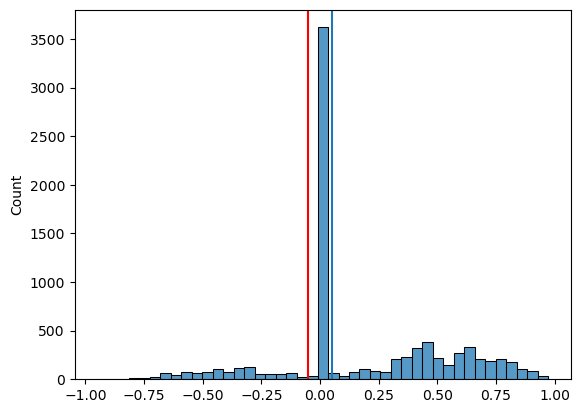

In [42]:
# This graph shows the overall number and range of sentiments in the tweets. The two lines are indiciative
# of the cutoff between negative, neutral, and positive. All tweets on the left of the red line mean that they are negative,
# and all on the right side are positive. And between the two lines are the neutral tweets.

ax = sns.histplot(old_tweet_sentiment)
ax.axvline(-.05, color='r')
ax.axvline(.05)
plt.show()

Here we were able to observe that most common sentiment value shown in the tweets is 0. 

In [43]:
# Give values to sentiment compound and use the values to give word values to vader emotion
clean_old_df2['sentiment_compound']=old_tweet_sentiment

clean_old_df2.loc[clean_old_df2['sentiment_compound']>=.05, 'vader_emotion']='Positive'
clean_old_df2.loc[clean_old_df2['sentiment_compound']<=-.05, 'vader_emotion']='Negative'
clean_old_df2.loc[(clean_old_df2['sentiment_compound']>-.05)&(clean_old_df2['sentiment_compound']<.05), 'vader_emotion']='Neutral'

In [44]:
# Here we can observe that the number of tweets with negative sentiments is a bit less than a third of tweets with
# positive or neutral tweets.
clean_old_df2['vader_emotion'].value_counts()

Neutral     3643
Positive    3564
Negative    1099
Name: vader_emotion, dtype: int64

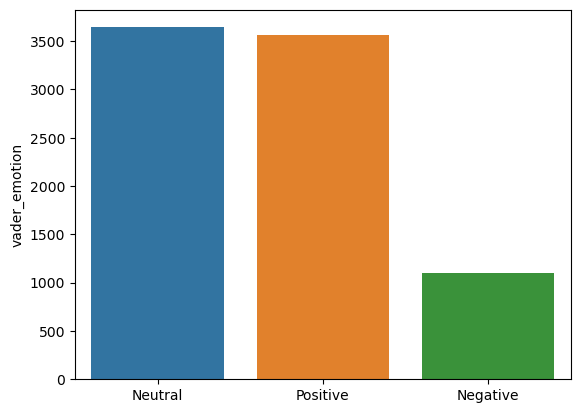

In [45]:
ax = sns.barplot(x=clean_old_df2['vader_emotion'].value_counts().index, y=clean_old_df2['vader_emotion'].value_counts())
plt.show()

In [46]:
clean_old_df2.head(15)
# show how many tweets did or didnt match

,product or company,emotion,clean_text,sentiment_compound,vader_emotion
0,Apple,Negative emotion,"I have a G iPhone. After hrs tweeting at , it was dead! I need to upgrade. Plugin stations at .",-0.6800,Negative
1,Apple,Positive emotion,"Know about ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at",0.9100,Positive
2,Apple,Positive emotion,Can not wait for also. They should sale them down at .,0.0000,Neutral
3,Apple,Negative emotion,I hope this year's festival isn't as crashy as this year's iPhone app.,0.7269,Positive
4,Google,Positive emotion,"great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",0.6249,Positive
5,Apple,No emotion toward brand or product,New iPad Apps For And Communication Are Showcased At The Conference,0.0000,Neutral
7,Android,Positive emotion,"is just starting, is around the corner and is only a hop skip and a jump from there, good time to be an fan",0.6369,Positive
8,Apple,Positive emotion,Beautifully smart and simple idea wrote about our iPad app for !,0.7712,Positive
9,Apple,Positive emotion,Counting down the days to plus strong Canadian dollar means stock up on Apple gear,0.5106,Positive
10,Android,Positive emotion,Excited to meet the at so I can show them my Sprint Galaxy S still running Android . .,0.3400,Positive


In [47]:
clean_old_df2[clean_old_df2['vader_emotion'].isna()]

,product or company,emotion,clean_text,sentiment_compound,vader_emotion


In [48]:
emotion_dict={'Positive emotion':'Positive', 'Negative emotion':'Negative', 'No emotion toward brand or product':'Neutral'}
for key, values in emotion_dict.items():
    clean_old_df2.loc[clean_old_df2['emotion'].str.contains(key, case=False), 'emotion']= values

In [49]:
# Try to find how many of these match
clean_old_df2['emotion_match'] = np.where(clean_old_df2['emotion'] == clean_old_df2['vader_emotion'], 'True','False')

In [50]:
clean_old_df2

,product or company,emotion,clean_text,sentiment_compound,vader_emotion,emotion_match
0,Apple,Negative,"I have a G iPhone. After hrs tweeting at , it was dead! I need to upgrade. Plugin stations at .",-0.6800,Negative,True
1,Apple,Positive,"Know about ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at",0.9100,Positive,True
2,Apple,Positive,Can not wait for also. They should sale them down at .,0.0000,Neutral,False
3,Apple,Negative,I hope this year's festival isn't as crashy as this year's iPhone app.,0.7269,Positive,False
4,Google,Positive,"great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",0.6249,Positive,True
...,...,...,...,...,...,...
9088,Apple,Positive,Ipad everywhere.,0.0000,Neutral,False
9089,Google,Neutral,"Wave, buzz... We interrupt your regularly scheduled geek programming with big news",-0.4939,Negative,False
9090,Google,Neutral,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. ""We're operating w/out data."" dev",0.0000,Neutral,True
9091,Apple,Neutral,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended .,-0.4019,Negative,False


In [51]:
print(clean_old_df2['emotion_match'].value_counts())
clean_old_df2['emotion_match'].groupby(clean_old_df2['vader_emotion']).value_counts()

True     4509
False    3797
Name: emotion_match, dtype: int64


vader_emotion  emotion_match
Negative       False             880
               True              219
Neutral        True             2503
               False            1140
Positive       True             1787
               False            1777
Name: emotion_match, dtype: int64

We are able to observe that around half of the previous sentiment analysis matches with the new vader sentiment analysis. We can see that the previous sentiment analysis did a poor job of identifying negative sentiments, was half and half for positive sentiments, and was able to correctly idenitfy a bit more than two-thirds of neutral sentiments

### New Tweet

In [52]:
new_tweet_sentiment=[]
for text in clean_new2['clean_text']:
    ss=sid.polarity_scores(text)
    new_tweet_sentiment.append(ss['compound'])
new_tweet_sentiment

[-0.6597,
 0.0772,
 0.9115,
 0.7213,
 0.0,
 0.0,
 0.1633,
 0.0,
 0.0772,
 0.0,
 0.0772,
 -0.5423,
 0.0,
 -0.2732,
 0.0,
 0.0,
 0.743,
 0.0,
 0.0,
 -0.2225,
 -0.5949,
 0.3257,
 0.4215,
 0.0,
 0.3311,
 0.9325,
 0.0,
 0.7568,
 -0.0516,
 0.4939,
 0.34,
 0.5439,
 -0.3565,
 0.0644,
 0.3096,
 0.6249,
 -0.2225,
 0.0,
 0.0,
 0.8668,
 0.0,
 -0.7088,
 0.0,
 0.2714,
 -0.3818,
 0.7964,
 0.0,
 -0.4184,
 0.4939,
 0.9042,
 0.4588,
 0.0,
 -0.2225,
 0.2263,
 -0.2987,
 0.0,
 0.0,
 -0.0258,
 0.1486,
 -0.296,
 -0.2225,
 0.5994,
 -0.4404,
 0.6124,
 0.3612,
 0.8957,
 -0.6597,
 -0.7845,
 0.8881,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.5423,
 -0.2225,
 -0.2225,
 0.0,
 0.0,
 0.4939,
 0.2732,
 0.0,
 0.8126,
 0.0,
 0.4019,
 0.7004,
 0.0,
 -0.296,
 -0.5423,
 -0.126,
 0.0,
 0.0,
 -0.775,
 0.0,
 -0.4588,
 -0.2225,
 0.0,
 0.5423,
 0.0,
 0.0,
 0.0,
 -0.2225,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.2225,
 0.7639,
 -0.3182,
 0.0,
 -0.2225,
 0.0,
 0.0258,
 0.8519,
 -0.2225,
 0.0,
 0.0,
 0.7783,
 0.0,
 0.2481,
 0.8402,
 0.0,
 0.2023,
 -0.2225,
 

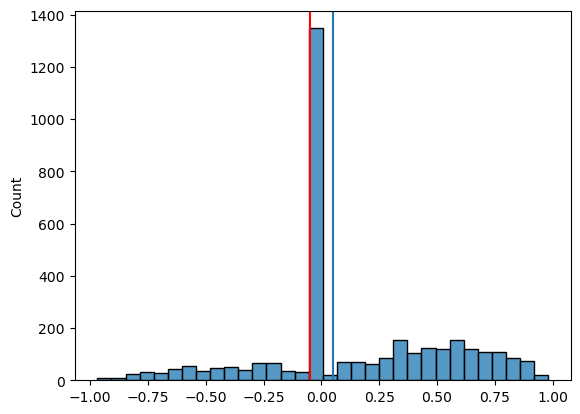

In [53]:
ax = sns.histplot(new_tweet_sentiment)
ax.axvline(-.05, color='r')
ax.axvline(.05)
plt.show()

This graph also shows great similarity to the previous one where 0 is the most common sentiment value

In [54]:
# Give values to sentiment compound and use the values to give word values to vader emotion
clean_new2['sentiment_compound']=new_tweet_sentiment

clean_new2.loc[clean_new2['sentiment_compound']>=.05, 'vader_emotion']='Positive'
clean_new2.loc[clean_new2['sentiment_compound']<=-.05, 'vader_emotion']='Negative'
clean_new2.loc[(clean_new2['sentiment_compound']>=-.05)&(clean_new2['sentiment_compound']<=.05), 'vader_emotion']='Neutral'

In [55]:
clean_new2.head()

,created_at,id,id_string,product or company,clean_text,sentiment_compound,vader_emotion
0,Fri Jul 09 15:55:27 +0000 2021,1413527226071588868,1413527226071588868,Apple,the fact that apple doesn t sync the contacts you blocked on your phone to your mac is sick. this man messaged me and it came thru to my laptop and for the paat two days i ve been debating cursing him out,-0.6597,Negative
1,Fri Jul 09 15:55:26 +0000 2021,1413527223252832257,1413527223252832257,Apple,j-armys doing the most for apple music yall pls stream there too,0.0772,Positive
5,Fri Jul 09 15:55:26 +0000 2021,1413527220727861251,1413527220727861251,Apple,"Please, if you can, if it's okay on your schedule, do join on the listening parties! You just have to go to the site and log in with you Spotify/Apple Music account and you can join the listening party already!",0.9115,Positive
6,Fri Jul 09 15:55:24 +0000 2021,1413527212641423362,1413527212641423362,Apple,"Due to I ll be blessing the first people that RETWEET & LIKE this tweet with $ - $ . Must have CashApp , Apple Pay or Zelle",0.7213,Positive
7,Fri Jul 09 15:55:23 +0000 2021,1413527209181126660,1413527209181126660,Apple,Opened Debris - Backlane request via iphone at A St SE Garbage piled in back lane.,0.0000,Neutral


In [56]:
clean_new2['vader_emotion'].value_counts()

Positive    1471
Neutral     1353
Negative     581
Name: vader_emotion, dtype: int64

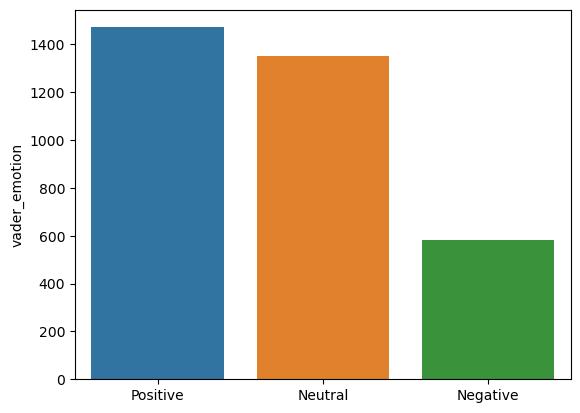

In [57]:
ax = sns.barplot(x=clean_new2['vader_emotion'].value_counts().index, y=clean_new2['vader_emotion'].value_counts())
plt.show()

The same can also be said of the individual emotions' value counts. Tweets with negative emotion are around a third of both positve and neutral tweets

## Tokenizing
Tokenizing is a process of splitting the tweet text into individual words and/or punctuation marks. This is considered one of the most important and foundational steps to performing NLP. 

### Old Tweet

In [58]:
# Create a list of all the common words in the old tweet
corpus_old = clean_old_df2['clean_text'].to_list()
token_list_old= word_tokenize(', '.join(corpus_old))

In [59]:
freq_dist=FreqDist(token_list_old)
freq_dist.most_common(10)

[(',', 11638),
 ('.', 5044),
 ('the', 3628),
 ('to', 3218),
 ('at', 2632),
 ('for', 2238),
 ('!', 2161),
 ('iPad', 2058),
 ('a', 2035),
 ('Google', 1984)]

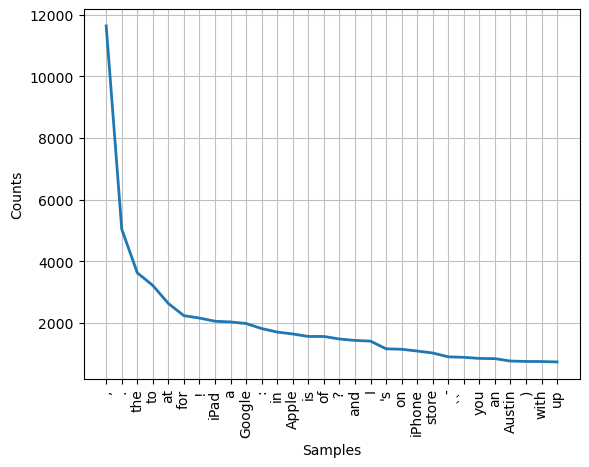

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [60]:
freq_dist.plot(30)

In [61]:
# Create a horizontal distribution of the most common words in the list
def common_word_hdist(word_list, n=30, figsize=(12,5)):
    freq_df = pd.DataFrame(word_list.most_common(100), columns=['Common Words','count']).sort_values('count', ascending=True)
    freq_df.set_index('Common Words').tail(n).plot(kind='barh', figsize=(12,5))
    plt.show()

### New Tweet

In [62]:
# Create a list of all the common words in the newer tweets
corpus_new = clean_new2['clean_text'].to_list()
token_list_new= word_tokenize(', '.join(corpus_new))

freq_dist_new=FreqDist(token_list_new)

In [63]:
freq_df_new = pd.DataFrame(freq_dist_new.most_common(100), columns=['Common Words','count']).sort_values('count', ascending=True)

### Both Tweets
I wanted to see which words were the most common in the tweets as well as which words should be included in the stopwords list. So after creating frequency distribution of the combination of both old and new tweets' clean text, I created a distribution plot of the most common words/characters

In [64]:
corpus_total = pd.concat([clean_old_df2['clean_text'],clean_new2['clean_text']]).to_list()
total_tokenlist = word_tokenize(', '.join(corpus_total))
freq_total = FreqDist(total_tokenlist)


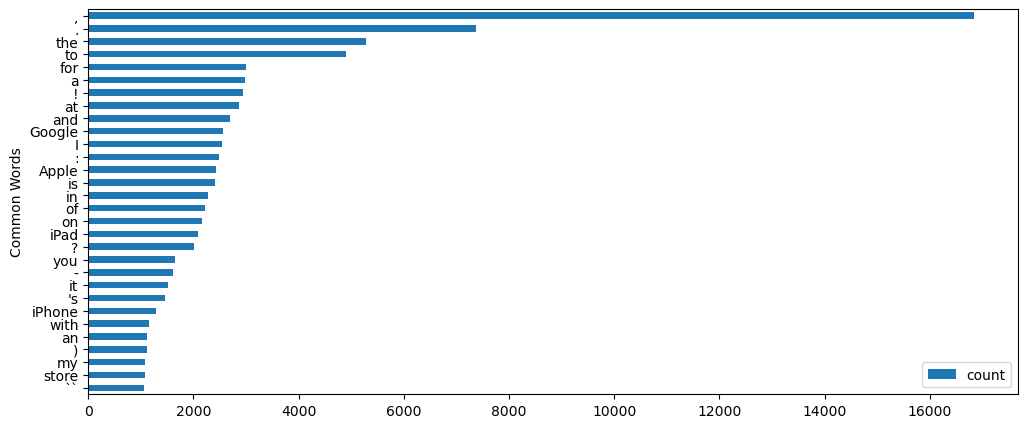

In [65]:
# frequency distribution of the most common words/characters in both tweets
common_word_hdist(freq_total)

In both the old and new tweets, punctuation marks were always on the top 30 most common characters. Other common words included the companies' names and products. I determined that these words/characters should be included in the stopwords list

### Stop Words

In [165]:
#Stop words
stop_words=stopwords.words('english')
stop_words.sort()
stop_words

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [166]:
# First I am including punctuation marks, common twitter phrases such as rt and mention;
# Quotation marks were also included since they were not part of the string.punctuation
# Finally, posessives such as 's and the company names and products were included in the stop words
stop_words.extend(string.punctuation)
stop_words.extend(['RT', 'mention','SXSW','link'])
stop_words.extend(['“','”','...',"''",'’','``'])
stop_words.extend(["'s","n't"])
stop_words.extend(['apple','google','android','apple','ipad','i-pad','iphone','austin'])

In [167]:
#Create new word cloud stop word list
wordcloud_stopwords=stop_words.copy()

In [70]:
# Removing stopwords from token lists
stopwords_removed_old = [x.lower() for x in token_list_old if x.lower() not in stop_words]
stopwords_removed_new = [x.lower() for x in token_list_new if x.lower() not in stop_words]
stopwords_removed_total = [x.lower() for x in total_tokenlist if x.lower() not in stop_words]

In [71]:
sw_freq_old = FreqDist(stopwords_removed_old)
sw_freq_new = FreqDist(stopwords_removed_new)
sw_freq_total = FreqDist(stopwords_removed_new)

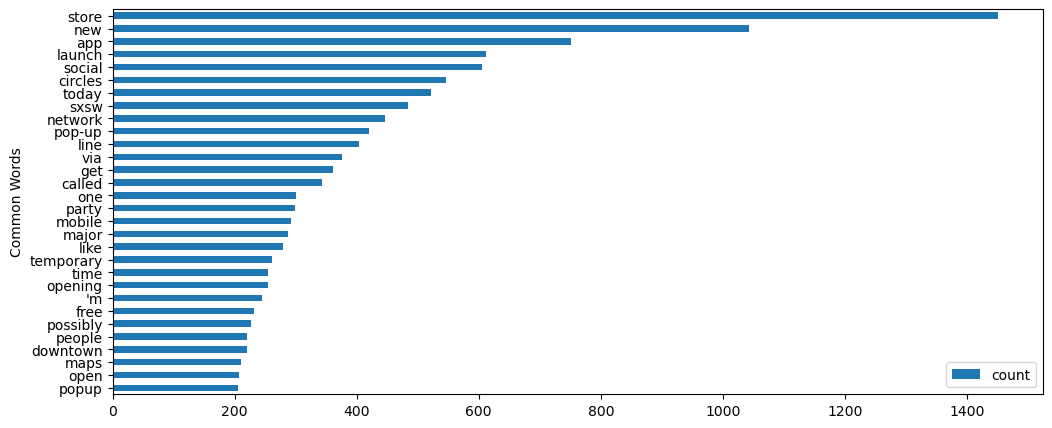

In [72]:
common_word_hdist(sw_freq_old)

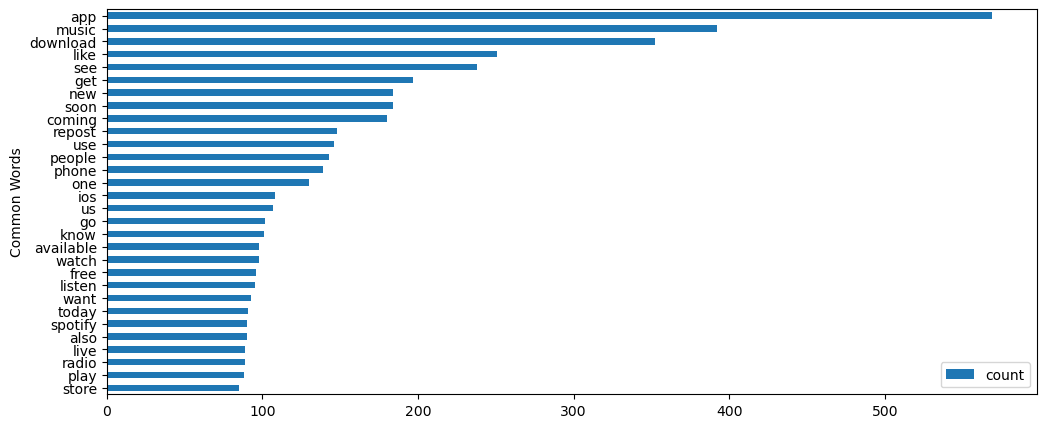

In [73]:
common_word_hdist(sw_freq_new)

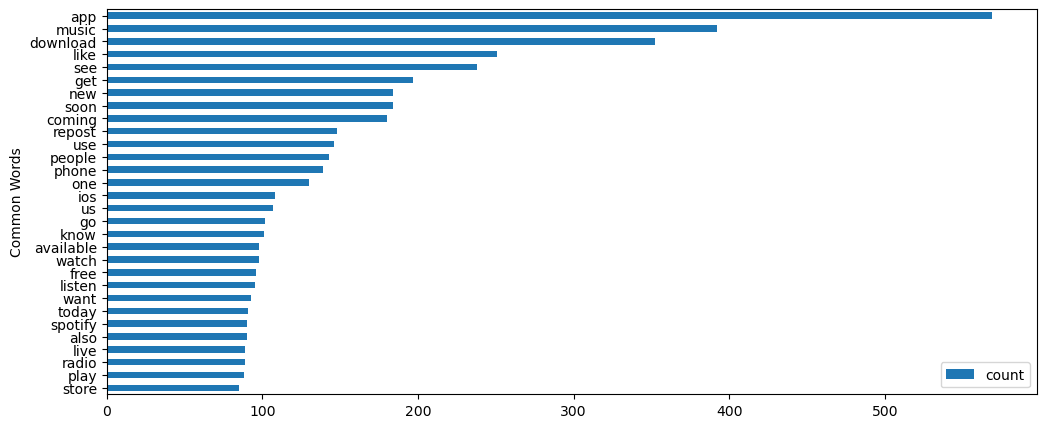

In [74]:
common_word_hdist(sw_freq_total)

In [75]:
t_tokenizer=TweetTokenizer(strip_handles=True, reduce_len=True)
t_token=[]
# for token in token_list:
for text in clean_old_df2['clean_text']:
    t_token.extend(t_tokenizer.tokenize(text))
# t_token

### Lemmatization
#### Old Tweets

In [76]:
lemmatizer = WordNetLemmatizer()
lemmatized_old_tweet = [lemmatizer.lemmatize(x) for x in token_list_old]
lemmatized_old_tweet[:5]

['I', 'have', 'a', 'G', 'iPhone']

#### New Tweets

In [77]:
lemmatized_new_tweet = [lemmatizer.lemmatize(x) for x in token_list_new]
lemmatized_new_tweet[:5]

['the', 'fact', 'that', 'apple', 'doesn']

In [78]:
# Vectorizer for modeling. it will do tokenizing for you. scikitlearn.vectorizer
# for twitter say tokenizer=tweettokenizer

# Using the compound(from vader), give sentiment first then create word clouds for positive, negative and neutral


## Old Tweet Modeling
For both the old tweets and new tweets, I used random forest and naive bayesian models. For the random forest models, I first made them without any parameters. Then I used pipelining and grid search cv to find the best parameters. For naive bayesian models, I created the base models then used grid search to improve the models' performance. 

### Preprocessing

In [79]:
old_X = clean_old_df2['clean_text'].copy()
old_y = clean_old_df2['vader_emotion'].copy()

In [80]:
# Train test split
old_X_train , old_X_test , old_y_train , old_y_test = train_test_split(old_X, old_y, test_size= .3, random_state= 334)

In [81]:
old_X_train

749                                                                 Google no lanzara ningun producto en South by SouthWest 
6767                                    The session is changing my mind about my future kid's relationship with the iPhone. 
7022                                                                                    Am I the only one left with an iPad 
3927                                                  Playing with my fave new iPhone app, Wow, this will rock at next week!
921                                         HootSuite News: HootSuite Mobile for ~ Updates for iPhone, BlackBerry & Android 
                                                                ...                                                         
2938              Lol at : "apple comes up with cool technology no one's ever heard of because they don't go to conferences"
8508                                                    P.S. and Google throw a b!tchin' party. Shout out to The Spazmatics 


In [82]:
old_y_train.isna().sum()

0

### Vectorization


In [83]:
vectorizer =TfidfVectorizer(tokenizer=t_tokenizer.tokenize,stop_words=stop_words)
old_X_train_tfidf = vectorizer.fit_transform(old_X_train)
old_X_test_tfidf = vectorizer.transform(old_X_test)
old_X_train_tfidf

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['rt', 'sxsw'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


<5814x6933 sparse matrix of type '<class 'numpy.float64'>'
	with 44123 stored elements in Compressed Sparse Row format>

In [84]:
len(vectorizer.vocabulary_)

6933

In [85]:
print(old_y_train.unique())

['Negative' 'Neutral' 'Positive']



### Random Forest

In [86]:
# Random Forest Modeling
rand_f=RandomForestClassifier(class_weight='balanced')
rand_f.fit(old_X_train_tfidf, old_y_train)

RandomForestClassifier(class_weight='balanced')

In [87]:
# give model score.
# model = sckitlearn model type

def model_score(model, X_test_tfidf, y_test, cmap='Blues', normalize='true', class_names=None, figsize=(12,6),
               X_train=None, y_train=None):
    # predictions and classification report
    print(metrics.classification_report(y_test, model.predict(X_test_tfidf), target_names=class_names))
    
    # Confusion Matrix

    metrics.plot_confusion_matrix(model, X_test_tfidf, y_test, cmap=cmap, normalize=normalize,
                                 display_labels=class_names)

    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tfidf,y_test):.2f}")
    plt.show()

              precision    recall  f1-score   support

    Negative       0.93      0.45      0.61       338
     Neutral       0.75      0.97      0.85      1091
    Positive       0.92      0.80      0.86      1063

    accuracy                           0.83      2492
   macro avg       0.87      0.74      0.77      2492
weighted avg       0.85      0.83      0.82      2492

Training Score = 1.00
Test Score = 0.83


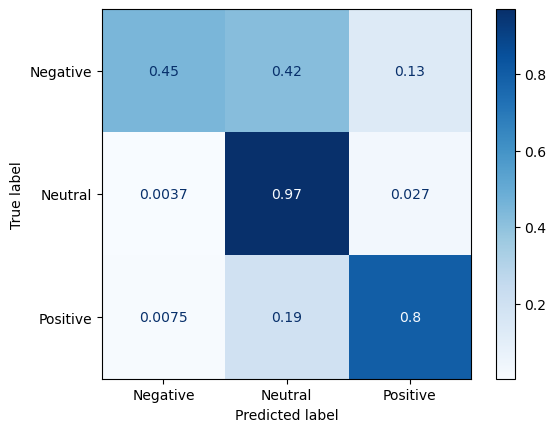

In [88]:
model_score(rand_f, old_X_test_tfidf, old_y_test, class_names=None,#old_y_train.unique(), 
            X_train=old_X_train_tfidf, y_train=old_y_train)

Tweets with neutral sentiments were most well identified. I believe that this is the case because of the small range given to neutral sentiments in vader sentiment analysis.

In [152]:
len(vectorizer.get_feature_names())

6933

In [153]:
len(rand_f.feature_importances_)

6933

After check to make sure that the length of the vectorizer's feature names and the number of features in the random forest model, I plotted the feature importance graph that shows the 30 most important features that the random forest model used to determine the tweets' sentiment.

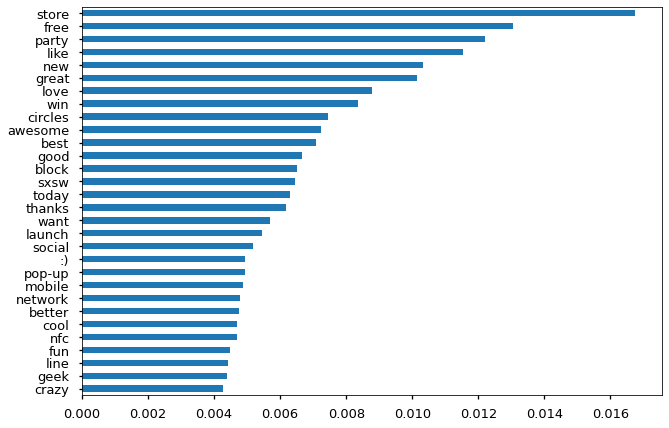

In [159]:
# Plotting the most important features that the random forest used
with plt.style.context('seaborn-talk'):
    old_impo=pd.Series(rand_f.feature_importances_,index=vectorizer.get_feature_names())
    old_impo.sort_values().tail(30).plot(kind='barh')

#### Random Forest GridSearch and NLP Pipeline

In [89]:
tweet_pipeline = Pipeline(steps=[('count_vectorizer',CountVectorizer()),
                            ('tf_transformer',TfidfTransformer(use_idf=True))])
tweet_pipeline

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tf_transformer', TfidfTransformer())])

In [90]:
old_X_train_pipe= tweet_pipeline.fit_transform(old_X_train)
old_X_test_pipe= tweet_pipeline.transform(old_X_test)
old_X_train_pipe

<5814x6772 sparse matrix of type '<class 'numpy.float64'>'
	with 76494 stored elements in Compressed Sparse Row format>

In [91]:
model_pipeline=Pipeline([('tweet_pipe', tweet_pipeline), 
                         ('clf', RandomForestClassifier(class_weight='balanced'))])
model_pipeline

Pipeline(steps=[('tweet_pipe',
                 Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                 ('tf_transformer', TfidfTransformer())])),
                ('clf', RandomForestClassifier(class_weight='balanced'))])

              precision    recall  f1-score   support

    Negative       0.92      0.42      0.57       338
     Neutral       0.73      0.92      0.82      1091
    Positive       0.83      0.76      0.79      1063

    accuracy                           0.78      2492
   macro avg       0.83      0.70      0.73      2492
weighted avg       0.80      0.78      0.77      2492

Training Score = 1.00
Test Score = 0.78


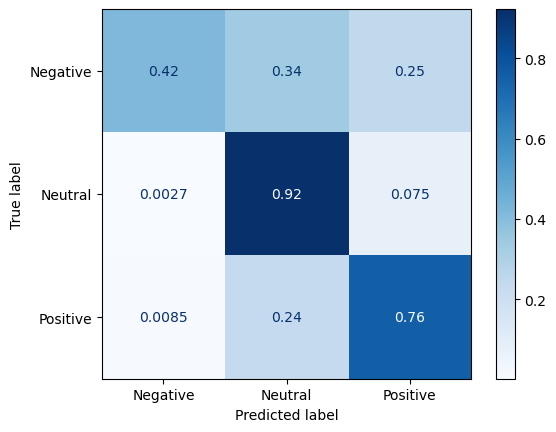

In [92]:
model_pipeline.fit(old_X_train, old_y_train)
model_score(model_pipeline, old_X_test, old_y_test, X_train=old_X_train, y_train= old_y_train)

After performing the pipeline, we see that the performance has decreased for the model. 

In [93]:
params = {'tweet_pipe__tf_transformer__use_idf':[True,False],
          'tweet_pipe__tf_transformer__norm':['l2','l1'],
          'tweet_pipe__tf_transformer__smooth_idf':[True,False],
          'tweet_pipe__count_vectorizer__stop_words':[stop_words,None],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 10, 30, 50, 75]
         }

In [94]:
gs= GridSearchCV(model_pipeline, params, cv=3, scoring='recall_macro', n_jobs=-1, verbose = 2)
gs.fit(old_X_train, old_y_train)
gs.best_params_

Fitting 3 folds for each of 160 candidates, totalling 480 fits


F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pad', 'rt', 'sxsw'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


{'clf__criterion': 'entropy',
 'clf__max_depth': 75,
 'tweet_pipe__count_vectorizer__stop_words': ['a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  "mightn't",
  'more',
  'most',
  'mustn',
  "mustn't",
  'my',

              precision    recall  f1-score   support

    Negative       0.64      0.54      0.59       338
     Neutral       0.75      0.91      0.82      1091
    Positive       0.90      0.75      0.82      1063

    accuracy                           0.79      2492
   macro avg       0.76      0.73      0.74      2492
weighted avg       0.80      0.79      0.79      2492

Training Score = 0.94
Test Score = 0.79


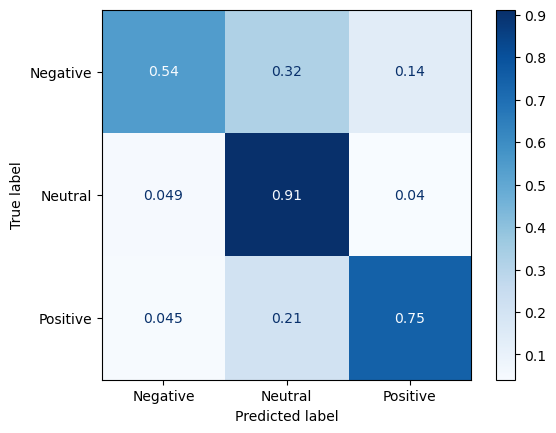

In [95]:
model_score(gs.best_estimator_, old_X_test, old_y_test, X_train= old_X_train, y_train= old_y_train)

The gridsearch helped improve identifying tweets with negative sentiments, but the recall score for the neutral and positive tweets have decreased by nearly identical amount.
However, I believe that this is the best model for the old tweets' sentiment analysis as the recall score for both the neutral and positive sentiments were acceptable, and the recall score for negative sentiments were above .5

### Naive Bayesian Classification

In [96]:
# n_bayes = GaussianNB()
n_bayes = MultinomialNB()
n_bayes.fit(old_X_train_pipe, old_y_train)

MultinomialNB()

              precision    recall  f1-score   support

    Negative       1.00      0.06      0.11       338
     Neutral       0.74      0.80      0.77      1091
    Positive       0.69      0.84      0.76      1063

    accuracy                           0.72      2492
   macro avg       0.81      0.57      0.55      2492
weighted avg       0.75      0.72      0.67      2492

Training Score = 0.81
Test Score = 0.72


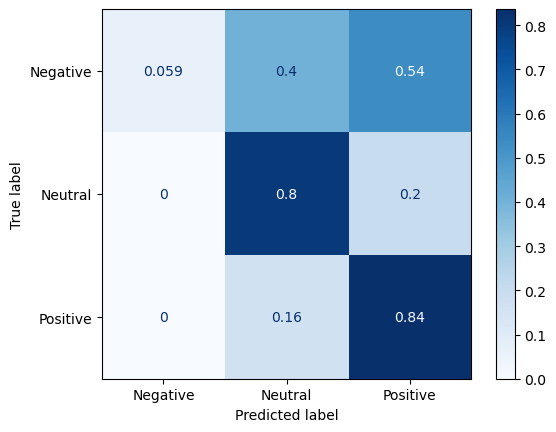

In [97]:
model_score(n_bayes, old_X_test_pipe, old_y_test, X_train= old_X_train_pipe, y_train= old_y_train)

Compared to the random forest model, the naive bayesian model performed significantly worse, especially for tweets with negative sentiments.
Even with the smaller size of the negative tweets, the low recall rate of .059 seems to be extraneous.

In [98]:
bayes_pipeline= Pipeline(steps=[('tweet_pipe', tweet_pipeline), ('clf', MultinomialNB())])

params = {'tweet_pipe__tf_transformer__use_idf':[True, False],
          'tweet_pipe__tf_transformer__norm':['l2','l1'],
          'tweet_pipe__tf_transformer__use_idf':[True,False],
          'tweet_pipe__tf_transformer__smooth_idf':[True,False],
#           'tweet_pipe__count_vectorizer__tokenizer':[ 
# #               None,                                       
#               TweetTokenizer(preserve_case=True).tokenize,
#               TweetTokenizer(preserve_case=False).tokenize],
          
          'tweet_pipe__count_vectorizer__stop_words':[None,stop_words],
#           'tweet_pipe__count_vectorizer__max_df':[1.0,0.95,0.9],
#           'ttweet_pipe__count_vectorizer__min_df':[1,2,3],
          
         'clf__alpha':[0, 1],
         'clf__fit_prior':[True,False]}
gs = GridSearchCV(bayes_pipeline, params, cv=3, scoring = 'recall_macro', n_jobs=-1, verbose =2)
gs.fit(old_X_train, old_y_train)
gs.best_params_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pad', 'rt', 'sxsw'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


{'clf__alpha': 0,
 'clf__fit_prior': False,
 'tweet_pipe__count_vectorizer__stop_words': ['a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  "mightn't",
  'more',
  'most',
  'mustn',
  "mustn't",
  'my',
  'mysel

              precision    recall  f1-score   support

    Negative       0.52      0.54      0.53       338
     Neutral       0.84      0.72      0.77      1091
    Positive       0.74      0.85      0.79      1063

    accuracy                           0.75      2492
   macro avg       0.70      0.70      0.70      2492
weighted avg       0.76      0.75      0.75      2492

Training Score = 0.95
Test Score = 0.75


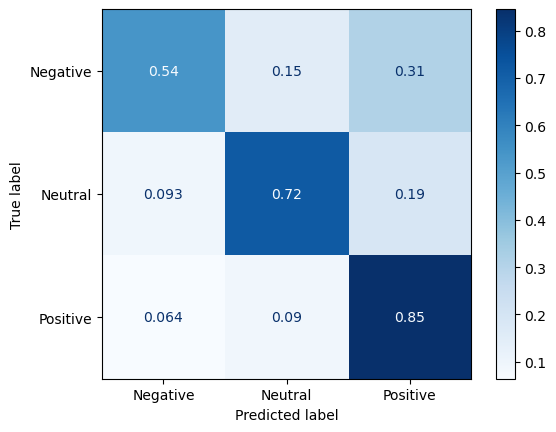

In [99]:
model_score(gs.best_estimator_, old_X_test, old_y_test, X_train= old_X_train, y_train = old_y_train)

After performing the grid search for the naive bayesian model, the results improved dramatically. The recall score for the negative tweets were slightly better than the random forest models, but the overall recall scores were lower than the rf models

## New Tweet Modeling


### Preprocessing

In [100]:
# move for each new tweet old tweet. move x and y above the models

In [101]:
new_X = clean_new2['clean_text'].copy()
new_y = clean_new2['vader_emotion'].copy()

In [102]:
new_X_train , new_X_test , new_y_train , new_y_test = train_test_split(new_X, new_y, test_size=.3, random_state=334)
new_X_train

4421                                                                                      Homescreen for Today Kggm Material for Kwgt by Wallpaper by Hishoot Template by 
1542             I just google things. You can always rely on google to tell you anything. And YouTube! So many times that had saved me by giving me a visual walkthrough!
3041                                                                                                           YouTube TV Picks Up Three New Add-On Channels For $ . Each 
4127                                                                                                                                                      Make your case! 
659                                                                      Damn. Apple is gonna bring the hammer down. Shifts will go from to hours at their overseas plant.
                                                                                       ...                                                       

### Vectorization

In [103]:
new_vectorizer = TfidfVectorizer(tokenizer=t_tokenizer.tokenize,stop_words=stop_words)
new_X_train_tfidf = new_vectorizer.fit_transform(new_X_train) 
new_X_test_tfidf = new_vectorizer.transform(new_X_test)
new_X_train_tfidf

F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['rt', 'sxsw'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


<2383x6757 sparse matrix of type '<class 'numpy.float64'>'
	with 23359 stored elements in Compressed Sparse Row format>

In [104]:
new_y_train.unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

### Random Forest

In [105]:
rand_f2=RandomForestClassifier(class_weight='balanced')
rand_f2.fit(new_X_train_tfidf, new_y_train)

RandomForestClassifier(class_weight='balanced')

              precision    recall  f1-score   support

    Negative       0.88      0.32      0.47       175
     Neutral       0.66      0.95      0.78       406
    Positive       0.84      0.71      0.77       441

    accuracy                           0.74      1022
   macro avg       0.79      0.66      0.67      1022
weighted avg       0.77      0.74      0.72      1022

Training Score = 1.00
Test Score = 0.74


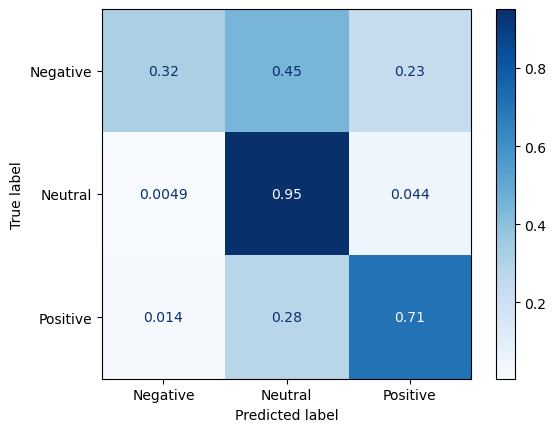

In [106]:
model_score(rand_f2, new_X_test_tfidf, new_y_test, class_names=None,
            X_train = new_X_train_tfidf, y_train = new_y_train)

The number of tweets with negative sentiments were also mirrored with the older tweets (a third of positive or neutral), and the results are also similar with the highest recal score for neutral tweets.

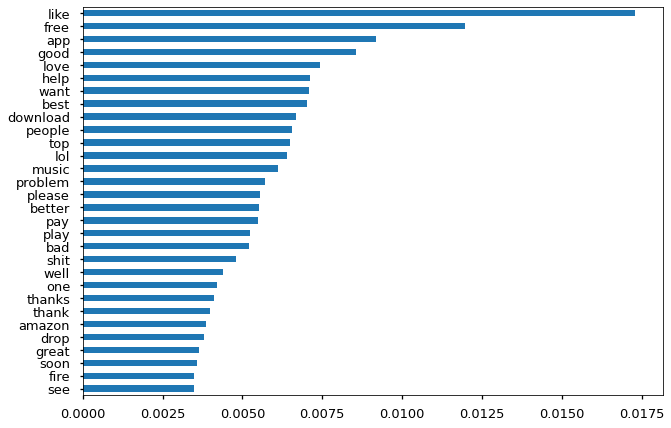

In [161]:
# Showing the most important features that the random forest used for the new tweets.
with plt.style.context('seaborn-talk'):
    new_impo=pd.Series(rand_f2.feature_importances_,index=new_vectorizer.get_feature_names())
    new_impo.sort_values().tail(30).plot(kind='barh')

Here, again, I plotted the 30 most important words that the random forest model used to determine the tweets' sentiment. Words such as like, free, love, and best could be observed at the top of the list in both feature importance analysis

#### Pipeline

              precision    recall  f1-score   support

    Negative       0.91      0.22      0.36       175
     Neutral       0.68      0.82      0.74       406
    Positive       0.70      0.78      0.74       441

    accuracy                           0.70      1022
   macro avg       0.76      0.61      0.61      1022
weighted avg       0.73      0.70      0.67      1022

Training Score = 1.00
Test Score = 0.70


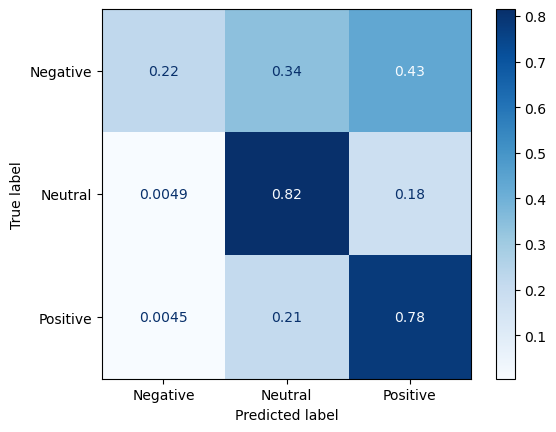

In [107]:
tweet_pipeline_new = Pipeline(steps=[('count_vectorizer',CountVectorizer()),
                            ('tf_transformer',TfidfTransformer(use_idf=True))])


new_X_train_pipe= tweet_pipeline.fit_transform(new_X_train)
new_X_test_pipe= tweet_pipeline.transform(new_X_test)


model_pipeline_new=Pipeline([('tweet_pipe', tweet_pipeline), 
                         ('clf', RandomForestClassifier(class_weight='balanced'))])


model_pipeline_new.fit(new_X_train, new_y_train)
model_score(model_pipeline_new, new_X_test, new_y_test, X_train=new_X_train, y_train= new_y_train)

Compared to the old tweets' random forest model with pipeline, there is a slight increase in the recall score for tweets with positive sentiment. However, like in the old tweets' model, the overall performance has decreased compared to the rf model without pipelining.

#### GridSearch CV

In [108]:
params = {'tweet_pipe__tf_transformer__use_idf':[True,False],
          'tweet_pipe__tf_transformer__norm':['l2','l1'],
          'tweet_pipe__tf_transformer__smooth_idf':[True,False],
          'tweet_pipe__count_vectorizer__stop_words':[stop_words,None],
          'tweet_pipe__count_vectorizer__max_df':[1.0,0.95],
          'tweet_pipe__count_vectorizer__min_df':[1,2,3],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 10, 30, 50, 75]
         }

gs_new= GridSearchCV(model_pipeline_new, params, cv=3, scoring='recall_macro', n_jobs=-1, verbose = 2)
# SCORING RECALL MACRO IF I GET ALL THE NANS
gs_new.fit(new_X_train, new_y_train)
gs_new.best_params_

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pad', 'rt', 'sxsw'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


{'clf__criterion': 'entropy',
 'clf__max_depth': None,
 'tweet_pipe__count_vectorizer__max_df': 1.0,
 'tweet_pipe__count_vectorizer__min_df': 3,
 'tweet_pipe__count_vectorizer__stop_words': ['a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',
  'm',
 

              precision    recall  f1-score   support

    Negative       0.66      0.35      0.46       175
     Neutral       0.67      0.89      0.76       406
    Positive       0.83      0.74      0.79       441

    accuracy                           0.73      1022
   macro avg       0.72      0.66      0.67      1022
weighted avg       0.74      0.73      0.72      1022

Training Score = 0.99
Test Score = 0.73


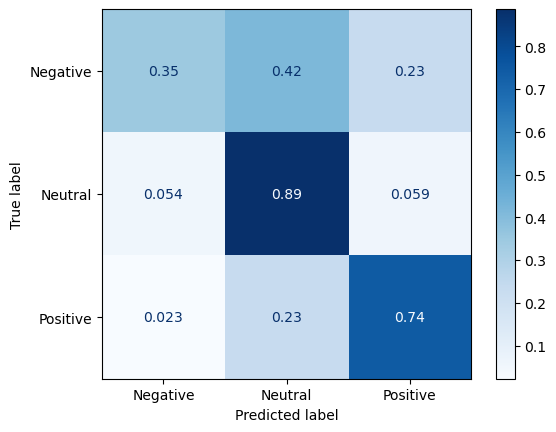

In [109]:
model_score(gs_new.best_estimator_, new_X_test, new_y_test, X_train= new_X_train, y_train = new_y_train)

The recall scores for negative tweets has slightly improved compared to the original rf model of the new tweets, but the recall scores of the other tweets have decreased by a similar amount to that increase.
However, like the rf models of the old tweets, I believe that the rf models after the gridsearch are the best because it maintains a relatively high recall score for the positive and neutral tweets while improving the recall score for the negative tweets.

### Naive Bayesian

In [110]:
n_bayes_new = MultinomialNB()
n_bayes_new.fit(new_X_train_pipe, new_y_train)

MultinomialNB()

              precision    recall  f1-score   support

    Negative       1.00      0.13      0.22       175
     Neutral       0.78      0.52      0.62       406
    Positive       0.56      0.93      0.70       441

    accuracy                           0.63      1022
   macro avg       0.78      0.52      0.51      1022
weighted avg       0.72      0.63      0.59      1022

Training Score = 0.77
Test Score = 0.63


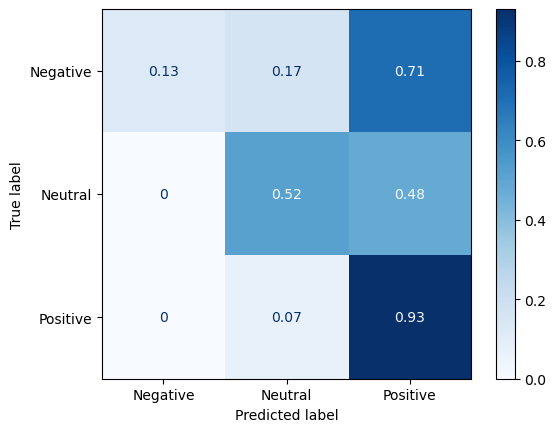

In [111]:
model_score(n_bayes_new, new_X_test_pipe, new_y_test, X_train= new_X_train_pipe, y_train= new_y_train )

The recall score for the negative and neutral tweets are far lower than those from the random forest model. Overall, the naive bayesian models did not perform well before performing the gridsearch.

#### Naive Bayesian GridSearch

In [112]:
bayes_pipeline_new= Pipeline(steps=[('tweet_pipe', tweet_pipeline), ('clf', MultinomialNB())])

params = {'tweet_pipe__tf_transformer__use_idf':[True, False],
          'tweet_pipe__tf_transformer__norm':['l2','l1'],
          'tweet_pipe__tf_transformer__use_idf':[True,False],
          'tweet_pipe__tf_transformer__smooth_idf':[True,False],
          'tweet_pipe__count_vectorizer__stop_words':[None,stop_words],    
         'clf__alpha':[0, 1],
         'clf__fit_prior':[True,False]}
gs_new = GridSearchCV(bayes_pipeline_new, params, cv=3, scoring = 'recall_macro', n_jobs=-1, verbose =2)
gs_new.fit(new_X_train, new_y_train)
gs_new.best_params_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


F:\Anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


{'clf__alpha': 0,
 'clf__fit_prior': False,
 'tweet_pipe__count_vectorizer__stop_words': None,
 'tweet_pipe__tf_transformer__norm': 'l2',
 'tweet_pipe__tf_transformer__smooth_idf': True,
 'tweet_pipe__tf_transformer__use_idf': False}

              precision    recall  f1-score   support

    Negative       0.48      0.46      0.47       175
     Neutral       0.79      0.54      0.64       406
    Positive       0.63      0.83      0.72       441

    accuracy                           0.65      1022
   macro avg       0.63      0.61      0.61      1022
weighted avg       0.67      0.65      0.64      1022

Training Score = 0.98
Test Score = 0.65


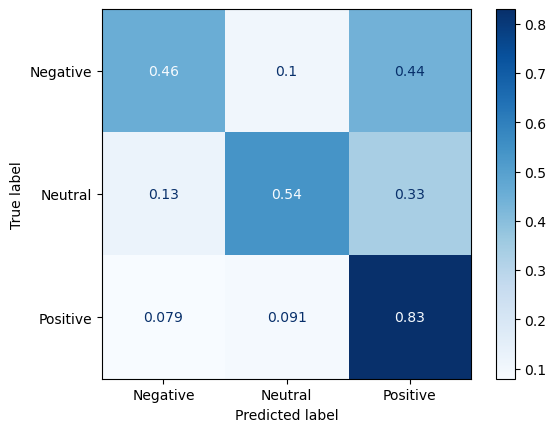

In [113]:
model_score(gs_new.best_estimator_, new_X_test, new_y_test, X_train= new_X_train, y_train = new_y_train)

While the recall scores have improved prior to the gridsearch, the recalls core for the neutral tweets are still far too low considering the number of neutral tweets.

## Word Cloud
Move this section to above the modeling section

In [114]:
# Wordcloud Generator
def wordcloud_generator(text, cmap, stopwords=None, min_font=12, n_grams=True, title='Word Cloud'): 
    # check out the api for wordcloud for stopwords                        
    #Use the title argument to show company and other info
    cloud = WordCloud(colormap=cmap, stopwords=stop_words, width=650, height=400, min_font_size=min_font,\
                      collocations=n_grams).generate(' '.join(text))#generate_from_text(' '.join(text))#
    fig, ax = plt.subplots(figsize=(12,7))
    ax.imshow(cloud)
    ax.set_axis_off()
    ax.set_title(title)
    ax.margins(x=0, y=0)
    ax.axis('off')
    plt.show()

In [115]:
# generate word clouds for each negative positive neutral. compare what words have chagned

In [116]:
old_positive = clean_old_df2.loc[clean_old_df2['vader_emotion']=='Positive'].copy()
old_negative = clean_old_df2.loc[clean_old_df2['vader_emotion']=='Negative'].copy()
old_neutral = clean_old_df2.loc[clean_old_df2['vader_emotion']=='Neutral'].copy()
new_positive = clean_new2.loc[clean_new2['vader_emotion']=='Positive'].copy()
new_negative = clean_new2.loc[clean_new2['vader_emotion']=='Negative'].copy()
new_neutral = clean_new2.loc[clean_new2['vader_emotion']=='Neutral'].copy()

In [117]:
old_positive

,product or company,emotion,clean_text,sentiment_compound,vader_emotion,emotion_match
1,Apple,Positive,"Know about ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at",0.9100,Positive,True
3,Apple,Negative,I hope this year's festival isn't as crashy as this year's iPhone app.,0.7269,Positive,False
4,Google,Positive,"great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",0.6249,Positive,True
7,Android,Positive,"is just starting, is around the corner and is only a hop skip and a jump from there, good time to be an fan",0.6369,Positive,True
8,Apple,Positive,Beautifully smart and simple idea wrote about our iPad app for !,0.7712,Positive,True
...,...,...,...,...,...,...
9073,Apple,Neutral,At your iphone charger is your best friend.,0.8126,Positive,False
9077,Apple,Positive,your PR guy just convinced me to switch back to iPhone. Great coverage.,0.7783,Positive,True
9079,Apple,Positive,"""papyrus...sort of like the ipad"" - nice! Lol! Lavelle",0.8264,Positive,True
9080,Google,Negative,"Diller says Google TV ""might be run over by the PlayStation and the Xbox, which are essentially ready today.""",0.3612,Positive,False


In [118]:
clean_old_df2.head()

,product or company,emotion,clean_text,sentiment_compound,vader_emotion,emotion_match
0,Apple,Negative,"I have a G iPhone. After hrs tweeting at , it was dead! I need to upgrade. Plugin stations at .",-0.6800,Negative,True
1,Apple,Positive,"Know about ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at",0.9100,Positive,True
2,Apple,Positive,Can not wait for also. They should sale them down at .,0.0000,Neutral,False
3,Apple,Negative,I hope this year's festival isn't as crashy as this year's iPhone app.,0.7269,Positive,False
4,Google,Positive,"great stuff on Fri : Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",0.6249,Positive,True


### Apple Word Clouds

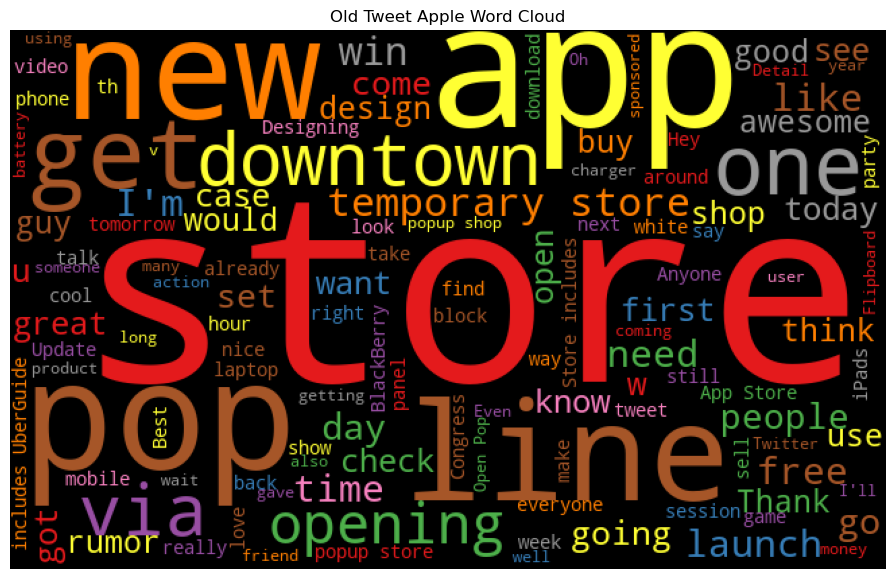

In [119]:
# Apple word cloud for old tweet
wordcloud_generator(text=clean_old_df2[clean_old_df2['product or company']=='Apple']['clean_text'], title='Old Tweet Apple Word Cloud',
                    cmap='Set1', stopwords=wordcloud_stopwords, min_font=12)

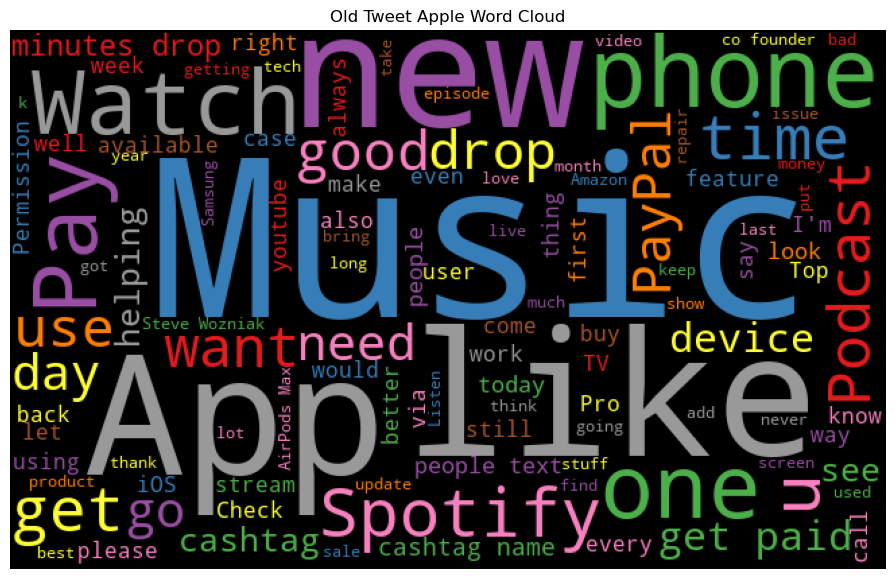

In [120]:
# Apple word cloud for new tweet
wordcloud_generator(text=clean_new2[clean_new2['product or company']=='Apple']['clean_text'], title='Old Tweet Apple Word Cloud',
                    cmap='Set1', stopwords=wordcloud_stopwords, min_font=12)

### Google Word Clouds

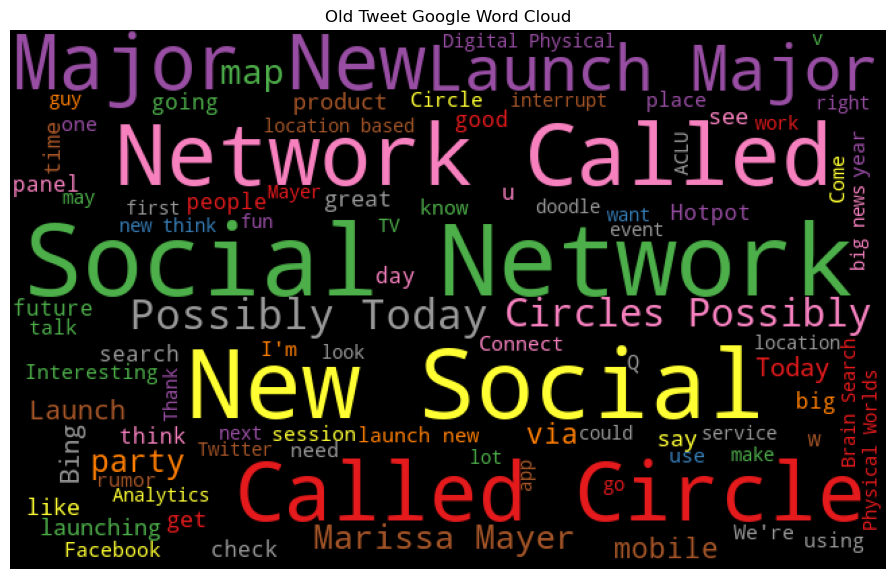

In [121]:
wordcloud_generator(text=clean_old_df2[clean_old_df2['product or company']=='Google']['clean_text'], title='Old Tweet Google Word Cloud',
                    cmap='Set1', stopwords=wordcloud_stopwords, min_font=12)

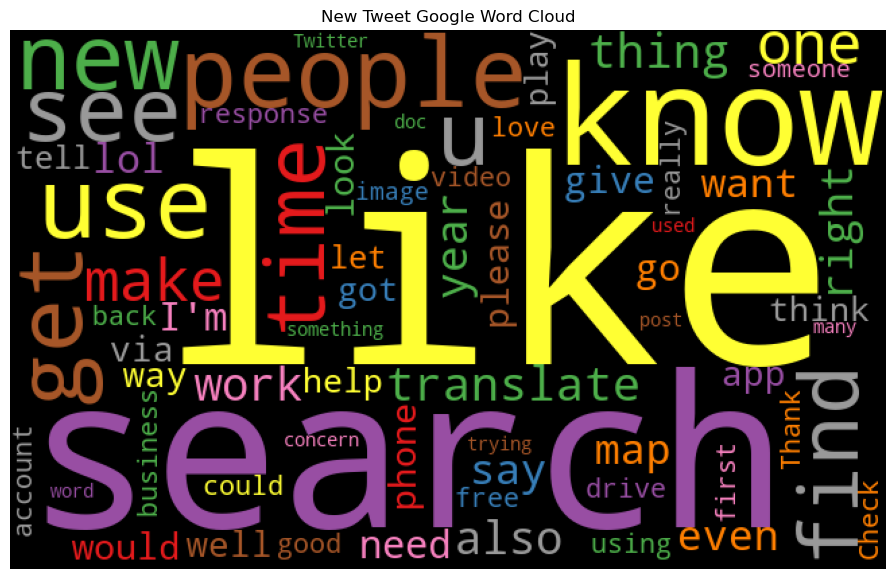

In [122]:
wordcloud_generator(text=clean_new2[clean_new2['product or company']=='Google']['clean_text'], title='New Tweet Google Word Cloud',
                    cmap='Set1', stopwords=wordcloud_stopwords, min_font=12)

### Android Word Clouds

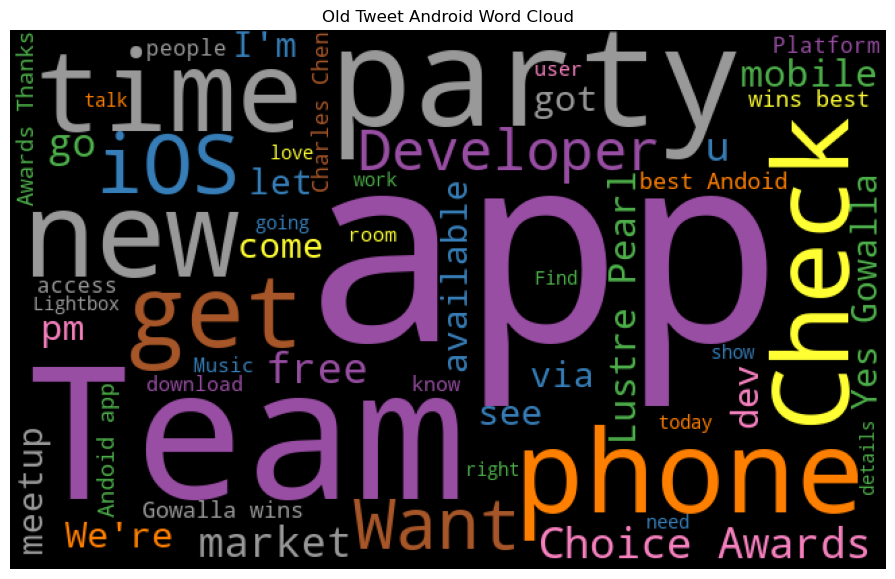

In [123]:
wordcloud_generator(text=clean_old_df2[clean_old_df2['product or company']=='Android']['clean_text'], title='Old Tweet Android Word Cloud',
                    cmap='Set1', stopwords=wordcloud_stopwords, min_font=12)

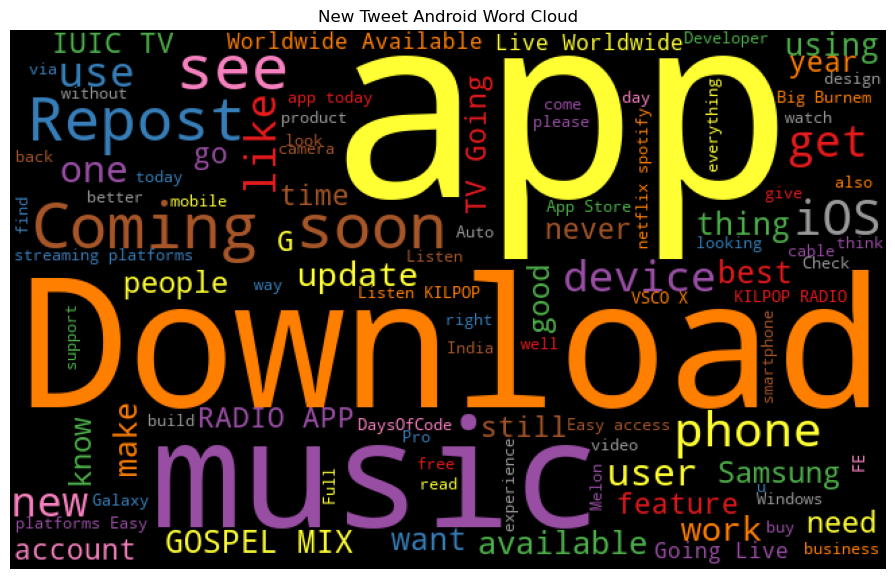

In [124]:
wordcloud_generator(text=clean_new2[clean_new2['product or company']=='Android']['clean_text'], title='New Tweet Android Word Cloud',
                    cmap='Set1', stopwords=wordcloud_stopwords, min_font=12)

In [125]:
# add markdown of what differences/changes i was able to see after changing the word clouds and
# comparing the old and new sentiments
# 

## Model Recommendation
For both of the tweets, the Random Forest models after the gridsearch performed the best. The random forest models before the pipeline and the models after performing the grid search performed similarly; however, because the low recall score for the negative tweets were improved to that of the original random forest models while maintaining the relatively high recall scores for the neutral and positive tweets, I recommend the **Random Forest models using gridsearch**.
As mentioned before, the number of tweets with negative sentiments were only a third of the size of either the positive or neutral neutral tweets which led to the poor recall rate of negative tweets for all models. 

## Conclusion
### Future Work
There are many things that I would like to incorporate into this project that I did not have the necessary skills or time to perform, but given the chance I would like to do these for the future:
1. Collect similar amounts of tweets for all three sentiments
    - This would help improve the recall scores for the models and maybe give an insight as to why the naive bayesian models did not perform as well before gridsearch.
2. Create a time line of sentiments and events.
    - By collecting tweets from the past throughout to the present, I would be able to show how the sentiment trends gradually changes.
    - Incorporating events from the past could also help understand the sentiment trends and highlight specific actions that the company had taken that negatively or positively impacted the public's sentiment.
3. Add the companies' earnings.
    - Adding the companies' earnings and comparing the relationship between the rate of increase in earnings to change in public sentiment shows a definitive reason to pay more attention to the public's wants/needs.
    - Adding a company that has continuously bettered its relationship with its end consumers and how their earnings have changed along with the public sentiment could show the difference that good public relationship can have on the company's earnings. 
<br> 
 <br>
 
### Final thoughts
This project was an adventure from the start as I had to learn how to collect my own data. Another aspect that I had not experienced before was the lengthy text cleaning that came with using tweets. And while the old tweet data were provided, I had to use the vader sentiment analysis as I had noticed much of the tweets did not correctly represent the tweet's sentiment. The aspect that most intrigued me about the Twitter sentiment towards these large companies is the obviously smaller number of negative emotion towards the companies and the overwhelming number of neutral sentiments towards them as well. I had initially expected to see a large increase in negative sentiment towards companies such as Apple as they have become less consumer friendly in their product designs. And as mentioned above in the future works section, I believe that creating a time line of the sentiment changes and events could help paint a clearer picture of how much these companies have changed in their policies and in the eyes of the consumers. 

# Dashboard

In [168]:
clean_old_df2.to_csv('old_twitter.csv')
clean_new2.to_csv('new_twitter.csv')

In [176]:
export_stop_words=stop_words.copy()
for stop in stop_words:
    export_stop_words.append(stop.capitalize())
pd.DataFrame(export_stop_words).to_csv('wordcloud_stopwords.csv')
# When exporting the stop words list, I had to do the above step because the word cloud function using streamlit was
# case sensitive even when collocations was set to false. After I had done this, it was able to filter out the 
# necessary stop words

In [177]:
from IPython.display import display, Markdown
with open('my_app.py') as file:
    display(Markdown("```python\n"+file.read()+'\n```'))

```python

import dash
import dash_core_components as dcc
import dash_html_components as html
from numpy.core.numeric import False_
import plotly.express as px
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
# %matplotlib inline
import matplotlib.image as mpimg
from PIL import Image
from wordcloud import WordCloud


old_tweet = pd.read_csv('old_twitter.csv')
new_tweet = pd.read_csv('new_twitter.csv')
stop_words = pd.read_csv('wordcloud_stopwords.csv')
stop_words = stop_words.iloc[:,1]
stop_words= stop_words.values.tolist()


select_company = st.sidebar.selectbox('Select company', ['Apple', 'Google', 'Android'])#old_tweet['product or company'].unique())
select_time = st.sidebar.selectbox('Old, New, or Both', ['Old', 'New', 'Both'], key='time')

emotion_data=old_tweet[old_tweet['vader_emotion']==select_company]
# select_status = st.sidebar.multiselect('Consumer sentiment of the company', ('Negative','Neutral','Positive'), default=['Neutral'])
# Instead of letting people select the sentiment, decided to show everything at the same time. 
# First because people aren't going to be confsued if all three are displayed. 
# Two, because it would update/change the result of the word cloud even though nothing about the sentiment information was inputed
# to the word cloud function. 

def to_dashboard(data):
    data=data[data['product or company']==select_company]
    my_tuple = (len(data[data['vader_emotion']=='Negative'])/len(data),
        len(data[data['vader_emotion']=='Neutral'])/len(data),
        len(data[data['vader_emotion']=='Positive'])/len(data))
    df = pd.DataFrame({
        'Emotion': ['Negative','Neutral','Positive'],
        'Number of Tweets' :my_tuple})
    return df
    # if len(select_status) == 0:
    #     pass
    # if len(select_status) == 1:
    #     # status_list=[select_status[0]]
    #     my_tuple = (len(data[data['vader_emotion']==select_status[0]]))/len(data)
    #     df = pd.DataFrame({
    #     'Emotion': select_status,
    #     'Number of Tweets' :my_tuple})
    #     return df
    # elif len(select_status) == 2:
    #     my_tuple = (len(data[data['vader_emotion']==select_status[0]])/len(data),
    #     len(data[data['vader_emotion']==select_status[1]])/len(data))
    #     df = pd.DataFrame({
    #     'Emotion': select_status,
    #     'Number of Tweets' :my_tuple})
    #     return df
    # elif len(select_status) == 3:
        # my_tuple = (len(data[data['vader_emotion']==select_status[0]])/len(data),
        # len(data[data['vader_emotion']==select_status[1]])/len(data),
        # len(data[data['vader_emotion']==select_status[2]])/len(data))
        # df = pd.DataFrame({
        # 'Emotion': select_status,
        # 'Number of Tweets' :my_tuple})
        # return df
def return_graph(select_time):
    if select_time == 'Old':
        tweet = to_dashboard(old_tweet)
        titler= select_company+ ' Old Tweet'
        graph = px.bar(tweet, x='Emotion',
                        y='Number of Tweets', title=titler)
        st.plotly_chart(graph)
    elif select_time== 'New':
        tweet = to_dashboard(new_tweet)
        titler= select_company+ ' New Tweet'
        graph = px.bar(tweet, x='Emotion',
                        y='Number of Tweets', title=titler)
        st.plotly_chart(graph)
    elif select_time == 'Both':
        tweet1 = to_dashboard(old_tweet)
        titler1= select_company+ ' Old Tweet'
        graph1 = px.bar(tweet1, x='Emotion',
                        y='Number of Tweets', title=titler1)
        tweet2 = to_dashboard(new_tweet)
        titler2= select_company+ ' New Tweet'
        graph2 = px.bar(tweet2, x='Emotion',
                        y='Number of Tweets', title= titler2)
        st.plotly_chart(graph1)
        st.plotly_chart(graph2)


def wordcloud_generator(text, cmap=None, stopwords=', '.join(str(stop) for stop in stop_words), min_font=12, colloc=True, title='Word Cloud'):

    cloud = WordCloud(colormap=cmap, stopwords=stopwords, width=650, height=400, min_font_size=min_font,
                      collocations=colloc).generate_from_text(' '.join(text))
    fig, ax = plt.subplots(figsize=(12,7))
    ax.imshow(cloud)
    ax.set_axis_off()
    ax.margins(x=0, y=0)
    ax.axis('off')
    st.image(cloud.to_array(), caption=title)

def wc_plot(select_company):

    wordcloud_generator(text=old_tweet[old_tweet['product or company']==select_company]['clean_text'], 
    cmap='Set1', title=f'Word Cloud Old Tweet {select_company}', stopwords=stop_words)
    
    wordcloud_generator(text=new_tweet[new_tweet['product or company']==select_company]['clean_text'], 
    cmap='Set1', title=f'Word Cloud New Tweet {select_company}', stopwords=stop_words)

if st.sidebar.checkbox('Show tweet emotion by company', True, key='2'):
    st.markdown('## **Comparison of Twitter Sentiment Analysis by Company**')
    return_graph(select_time)

if st.sidebar.checkbox('Show Wordcloud', True):
    st.markdown('## **Wordcloud**')
    wc_plot(select_company)
```